In [1]:
#some style formatting
from IPython.display import HTML
style = '''<style>
div.abstract_text {text-align: justify;text-justify: inter-word;}
div.text {text-align: justify; text-justify: inter-word;}
</style>'''
HTML(style)


<img typeof="foaf:Image" src="static/ANTI-INFECTIVES-RGB_200pc.png" alt="Wellcome Centre for Anti-Infectives Research" title="">

# ML Analysis for <i>T. brucei</i>

Michele Tinti and Michael A.J. Ferguson

Wellcome Centre for Anti-Infectives Research
School of Life Sciences, University of Dundee

## Abstract
<span>
<div class=abstract_text>
The number of Proteomics and Genomics experiments performed in laboratories is growing exponentially year after year. This massive amount of data pose new challenges to the scientific community. In particular, the amount of available data is not matched by the capacity of bioinformatic tools for retrieving and extracting useful insights from the publicly accessible datasets. On the other Hand, Machine Learning (ML) and Artificial Intelligence (AI) can mitigate this issue by providing powerful analysis tools.  However, data needs to be prepared and formatted for ML analysis. With the following code, we demonstrate the utility of ML applied to a practical example by asking: <mark>which features can predict the fast turnover of a protein in <i>T. brucei</i>?</mark>
</div> 
    
## Motivation
<span>
<div class=text>
Trypanosoma brucei, a protozoan parasite transmitted by the tsetse fly, causes Human African Trypanosomiasis (HAT) and Nagana in cattle. When a tsetse fly feeds on infected human or animal blood, stumpy form T. brucei trypomastigotes enter the insect midgut and differentiate into the proliferating procyclic form (PCF) cells. These migrate to the salivary glands and differentiate into proliferating epimastigote form cells and finally into non-dividing animal-infective metacyclic trypomastigotes. During a subsequent blood meal, the tsetse fly transmits the metacyclic trypomastigotes into the hemolymphatic system of the host where they transform into the rapidly proliferating slender bloodstream form (BSF), and the cycle of infection begins again. Current therapeutics for trypanosomiasis suffer from issues of toxicity (sometimes fatal side effects), the complexity of administration and the appearance of resistance. For these reasons, The Wellcome Centre for Anti-Infectives Research in Dundee (UK) is at the forefront of drug discovery efforts for trypanosomatid diseases. Recently, our Center has developed a strategies to try to identify proteins as potential drug targets. With this notebook, we want to use machine learning to gain a better understanding of these potential targets and to prioritise our efforts for drug discovery campaigns. 
</div> 

In [2]:
#set up code
%load_ext autoreload
%autoreload 2

In [3]:
from mylib import scripts
%run mylib/scripts.py
np.random.seed =1976

Using TensorFlow backend.


In [4]:
#os.environ["PATH"]

In [5]:
def check_Graphviz2(paths):
    for n in paths.split(os.pathsep):
        if 'Graphviz2' in n:
            print('Graphviz2 found')
            return True
    return False

if not check_Graphviz2(os.environ["PATH"]):
    #if Graphviz2 is not in your environ path
    #Install Graphviz2 and change the path accordingly
    path_to_Graphviz = os.path.join('C:',os.sep,
                                    'Program Files (x86)',
                                    'Graphviz2.38','bin')
    os.environ["PATH"] += os.pathsep + path_to_Graphviz

In [6]:
#uncomment to see if correct path is saved
#os.environ["PATH"]

##### Handy ML Vocabulary
 <ul>
  <li> <mark> Feature</mark>: Is a column of the dataset, a numerical or chategorical columns that tells us something about the trypanosome proteome.</li>
  <li><mark>Target Feature</mark>: Is the numerical or chategorical column that we are trying to predict.</li>
  <li><mark>Feature Importance</mark>: Is a score that AI models assign to the features, the higher is the score the most important is the feature.</li> 
  <li><mark>Profet, Fasta, Biopython, Pandas packages</mark>: Program libraries to facilitate the computation and analysis of protein features.</li> 
  <li><mark>Gradient Boosting</mark>: A type of machine learning algorithm that average the prediction of many classifiers.</li> 
  <li><mark>Fold cross validation </mark>: A type of machine learning technic to split the data, so that the AI alghoritm is trained on one part of the dataset and the performace is evalueted in another part of the dataset.</li> 
 
 <li><mark>AUC ROC score:</mark> Area Under the Curve of the Receiver Operating Characteristic Curve. A jargon to describe a scoring system for ML. The score goes from 0 to 1. The better is the ML algorithm, the closer the score is to 1.</li>
    
<li><mark> SHAP score:</mark>SHapley Additive exPlanations score is a unified approach to quantify the feature importance of a ML model. It derives from the game theory field, where has been used to quantify the contribution of each player to the success of a team.</li>
</ul> 

##### Handy Biology Vocabulary
<ul>
<li><mark>PCF</mark>: ProCyclic Form, the insect infective form of Trypanosoma brucei.</li>

<li><mark>BSF</mark>: BloodStream Form, the human infective form of Trypanosoma brucei.</li>

<li><mark>Glycosome</mark>: A cellular organelle peculiar to few protozoan including trypanosomes. It contains enzymes for glycolysis and beta oxidation of fatty acids.</li>

<li><mark>Homolog</mark>: describes an evolutionary relationship between genes and proteins based on their sequence similarity/identity.</li>

<li><mark>Ortholog</mark>: type of homolog, same gene/protein in different species. These are derived from a common ancestor gene through vertical descent.</li>

<li><mark>Paralog</mark>: type of homolog, same genes/proteins within the genome of a species. These are derived from a common ancestor gene through duplication events.</li>

<li><mark>Proteome</mark>: the entire set of proteins expressed by a cell</li>
<li><mark>SNPs</mark>: Single Nucleotide Polymorphisms, are a type of genetic variation. Each SNP represents a difference in a single DNA base (nucleotide). An important group of SNPs are those that corresponds to missense mutations (non sysnonimus) causing amino acid change on protein level. The sysnonimus SNPs introduce a change that do not alter the amino acid sequence. 
</li>

</ul> 

## Methods

<span>
<div class=text>
We created a dataset by re-visiting Proteomic, Transcriptomic and Genomic experiments deposited at the TriTrypDB database. Several of these experiments study the response of the <i>T. brucei</i> proteome / trascriptome as time course analyses. For such experiments, we create three features: the maximum fold change between any time point in the time course, the time point that shows the maximum expression of the protein/transcript and the time point that shows the minimum expression of the protein/transcript. Other experiments deposited in the TriTrypDB database study the difference of the T. brucei proteome / transcriptome between two conditions. For these experiments, targeted features are created on a case by case basis. Some features will be also created for experiments performed in our laboratory and not yet uploaded in the TriTrypDB database. Finally, we will show a few examples of exploiting our dataset by applying ML analysis. In this notebook we will model protein stability in <i>T. brucei</i>.    
</div> 

## Start

## Download the dataset
The input file was downloaded from TryTripDB. It is a data dump of all the deposited
experiments in TryTripDB for the Treu927 genome. This link (https://tritrypdb.org/tritrypdb/im.do?s=d7c5277bb3cfbf2d) show how to extract all the Treu927 gene ids from TryTripDB. To download the datayourself, just clic on the download tab in the middle of the TryTripBD web page<img typeof="foaf:Image" src="static/Capture_1.PNG" alt="Wellcome Centre for Anti-Infectives Research" title="">
### select the option indicated on the red arrows 
<img typeof="foaf:Image" src="static/Capture_2.PNG" alt="Wellcome Centre for Anti-Infectives Research" title="">



In [7]:
import pandas as pd
#load the dataset
#final_df = pd.read_csv('indata/GenesByTaxon_Summary_43.zip',sep='\t')
tryp_df = pd.read_csv(os.path.join('input','GenesByTaxon_Summary_44.zip'), sep='\t')
tryp_df.head()
print(tryp_df.shape)

(11832, 401)


### Time to create the ML dataset

In [8]:
#this is our ML dataset, ready to accept new features
ml_df = tryp_df[['Gene ID']].copy()

In [9]:
#There is a bug in the tritrypDB script that create the outputs
#some RNA-seq experiments have the same name for unique and nonunique values
#pandas assign to such duplicates column the '.1' suffix
len([n for n in tryp_df.columns if '.1' in n])
#also, some RNA-seq experiments are still missing the unique and nonunique tag

2






## Processing of proteomics data
### BSF PCF fold change

TryTripDB contains 6 proteomic datasets that analyse  the differential protein expression between the Procyclic form (PCF) and BloodStream form (BSF) parasites stages. Two datasets (<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_cb23da819c">Urbaniak 2012</a>  and <a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_24b68cb68a">Urbaniak 2013</a>) were produced in our research centre and two others were reported in <a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_1ec24003f1">Butter et al. 2013</a>. Two other experiments were produced by <a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_1e1fb1711d">Gunasekera K et al 2012 </a> differentiating between Long Slender (LS) and  Short Stumpy (SS) BSF life stage.
We now aim to visualize the similarities between these datasets.


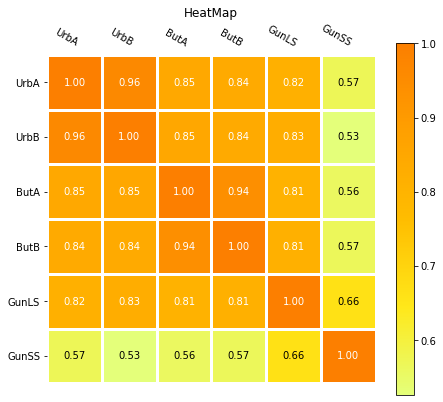

In [10]:
#columns with the data
proteomics_columns = ['Procyclic Form Vs Bloodstream Form (Tb PCFvBSF QProt SILAC)',
                     'Pcf-Bsf ratio (Tb PCF BSF QPhosProt)',
                    'Combined-PCF_light V BSF_heavy (Tb PCF BSF Prot SILAC-switch)',
                    'Combined-PCF_heavy V BSF_light (Tb PCF BSF Prot SILAC-switch)',
                         'LS (Tb927 LSvSS QProt)',
                         'SS (Tb927 LSvSS QProt)',]

rename = ['UrbA', 'UrbB', 'ButA', 
          'ButB','GunLS','GunSS']
#rename = ['1', '2', '3', '4']
temp_df = tryp_df[proteomics_columns]
temp_df.columns = rename

im, cbar, ax = scripts.heatmap(temp_df.corr().values,
                           temp_df.columns,temp_df.columns,cmap="Wistia")

texts = scripts.annotate_heatmap(im, valfmt="{x:.2f}")
plt.tight_layout()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(6, 6)
plt.title('HeatMap')
#ax.set_xticks([]) 
#ax.set_yticks([]) 

#ax.tick_params(axis=u'both', which=u'both',length=0)
plt.savefig(os.path.join('figures','example_1','Fig_1a.png'))
plt.show()

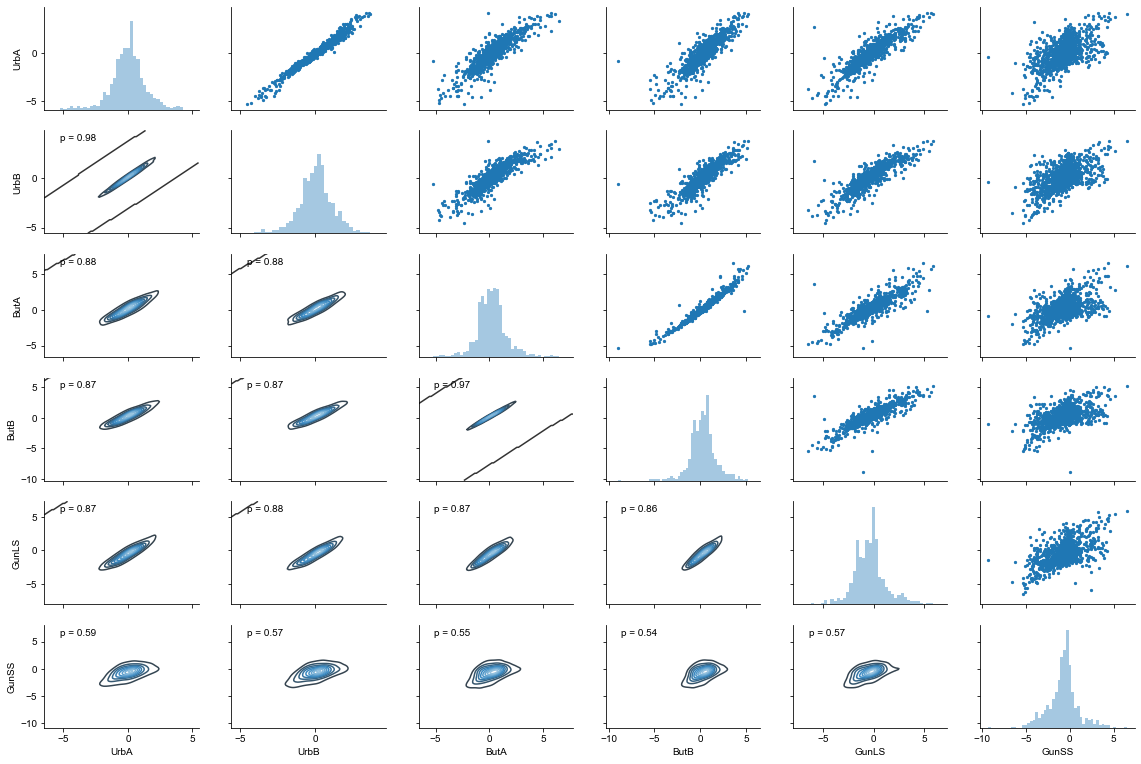

In [11]:
scripts.plot_correlation(temp_df.dropna(axis=0))
plt.savefig(os.path.join('figures','example_1','Fig_1b.png'))


The figure shows a good reproducibility between all the dataset. Now we normalize and average the dataset, but we keep the SS experimet out to be used as a descriptor by itself.

In [12]:
ss = StandardScaler()
del temp_df['GunSS']
temp_df=pd.DataFrame(ss.fit_transform(temp_df), 
                     columns=temp_df.columns,index=temp_df.index.values)
temp_df['merged']=temp_df.median(axis=1, skipna=True)

#### BSF PCF missing data

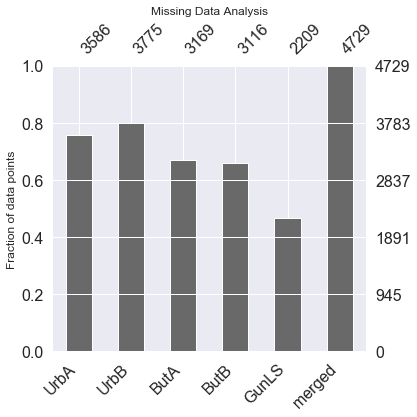

In [13]:
#visualization of missing data
ax=msno.bar(temp_df.dropna(axis=0, how='all'),figsize=(6, 6))
plt.title('Missing Data Analysis',size=12)
ax.set_ylabel('Fraction of data points',size=12)
#plt.xtickslabels(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join('figures','example_1','Fig_2.png'))
plt.show()

The merged dataset has less missing data points

In [14]:
#adding our merged feature
ml_df['EF_merged_PCF_BSF']=temp_df['merged'].values
ml_df['SS (Tb927 LSvSS QProt)']=tryp_df['SS (Tb927 LSvSS QProt)']
print(ml_df.shape)

#removing old stuff
del temp_df
gc.collect()

(11832, 3)


105217

### PCF Cell Cycle
Proteomic Analysis of the Cell Cycle of Procylic Form Trypanosoma brucei (<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_bf9c234fd9">TryTripDB</a>). We extract three features for each protein: the maximum fold change between all data points, the time point with the maximum abundance (hour) and the  time point with the minimum abundance (hour). 

In [15]:
list(tryp_df.columns)
#final_df[[n for n in final_df.columns  if 'Tb LifeCyc Marray' in n]].head()
cols = [n for n in tryp_df.columns  if 'Tb procyclic cell cycle proteome' in n]
print (cols)
temp_df = tryp_df[cols]
temp_df = temp_df.replace(0.0, np.nan)
ml_df['EF_CellCycle_min_max'] = np.log2(
    temp_df[cols].max(axis=1,skipna=True)/temp_df[cols].min(axis=1,skipna=True))
ml_df['EF_CellCycle_max'] = temp_df[cols].idxmax(axis=1)
ml_df['EF_CellCycle_max'] = [float(str(n).split(' ')[0]) for n in ml_df['EF_CellCycle_max']]
ml_df['EF_CellCycle_min'] = temp_df[cols].idxmin(axis=1)
ml_df['EF_CellCycle_min'] = [float(str(n).split(' ')[0]) for n in ml_df['EF_CellCycle_min']]

['0.5 hr (Tb procyclic cell cycle proteome)', '3 hr (Tb procyclic cell cycle proteome)', '5 hr (Tb procyclic cell cycle proteome)', '6 hr (Tb procyclic cell cycle proteome)', '7 hr (Tb procyclic cell cycle proteome)', '8 hr (Tb procyclic cell cycle proteome)', '9 hr (Tb procyclic cell cycle proteome)', '10 hr (Tb procyclic cell cycle proteome)', '11 hr (Tb procyclic cell cycle proteome)']


In [16]:
print(ml_df.shape)

(11832, 6)


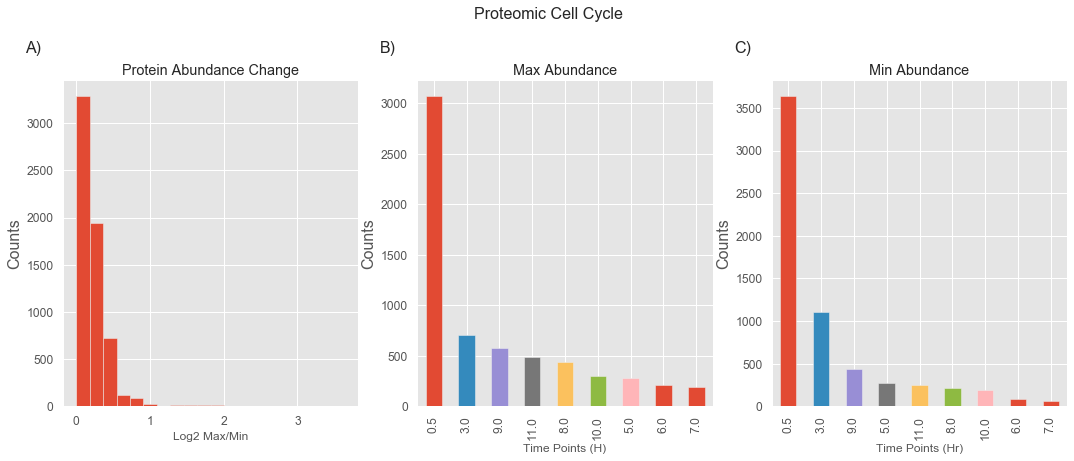

In [17]:
plt.style.use('ggplot')
fig,axes=plt.subplots(figsize=(18,6),ncols=3)
ml_df['EF_CellCycle_min_max'].plot(kind='hist', bins=20,ax=axes[0])
axes[0].set_xlabel('Log2 Max/Min',fontsize=12)
axes[0].set_ylabel('Counts', fontsize=16)
axes[0].set_title('Protein Abundance Change')
scripts.add_subplot_index(axes[0], text='A)')

ml_df['EF_CellCycle_max'].value_counts().plot(kind='bar',ax=axes[1])
axes[1].set_xlabel('Time Points (H)',fontsize=12)
axes[1].set_ylabel('Counts', fontsize=16)
axes[1].set_title('Max Abundance')
scripts.add_subplot_index(axes[1], text='B)')

ml_df['EF_CellCycle_min'].value_counts().plot(kind='bar',ax=axes[2])
axes[2].set_xlabel('Time Points (Hr)',fontsize=12)
axes[2].set_ylabel('Counts', fontsize=16)
axes[2].set_title('Min Abundance')
scripts.add_subplot_index(axes[2], text='C)')


plt.suptitle('Proteomic Cell Cycle',fontsize=16,y=1.05)
plt.savefig(os.path.join('figures','example_1','Fig_3.png'))
plt.show()

### BSF / PCF Protein Abundance
This dataset is under revison for publishing at Wellcome Open Research https://wellcomeopenresearch.org/ and is not yet implemented in TryTripDB. For the moment we will use this dataset to create a feature describing the abundance of a protein. It will later be used to extract fast and slow turnover protein for ML modeling.


In [18]:
bsf = pd.read_table(os.path.join('input','turnover','BSF','proteinGroups.zip'))
pcf = pd.read_table(os.path.join('input','turnover','PCF','proteinGroups.zip'))

intensity_columns = [n for n in bsf.columns if n.startswith('Intensity H') ]
bsf[intensity_columns]=bsf[intensity_columns].replace(0,np.nan)
bsf['abundance'] = np.log10(bsf[intensity_columns].mean(axis=1,skipna=True))

intensity_columns = [n for n in pcf.columns if n.startswith('Intensity H') ]
pcf[intensity_columns]=pcf[intensity_columns].replace(0,np.nan)
pcf['abundance'] = np.log10(pcf[intensity_columns].mean(axis=1, skipna=True))


temp_dict = scripts.make_dict_from_cols(bsf)
ml_df['EF_Abundance_BSF']=[temp_dict.get(n, np.nan) for n in tryp_df['Gene ID']]
temp_dict = scripts.make_dict_from_cols(pcf)
ml_df['EF_Abundance_PCF']=[temp_dict.get(n, np.nan) for n in tryp_df['Gene ID']]
print(ml_df.shape)

(11832, 8)


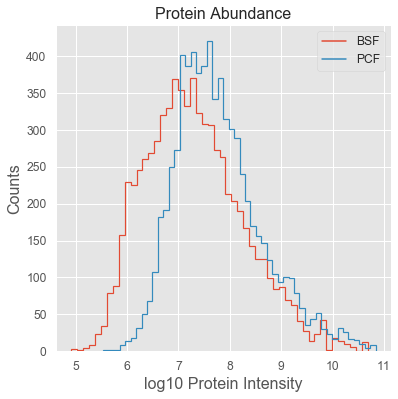

In [19]:
fig,ax=plt.subplots(figsize=(6,6))
from matplotlib.lines import Line2D
ml_df['EF_Abundance_BSF'].plot(kind='hist',histtype='step', ax=ax, label='BSF',linewidth=1.2,bins=50)
ml_df['EF_Abundance_PCF'].plot(kind='hist',histtype='step', ax=ax, label='PCF',linewidth=1.2,bins=50)
plt.xlabel('log10 Protein Intensity', fontsize=16)
plt.ylabel('Counts', fontsize=16)
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
plt.legend(handles=new_handles, labels=labels)
plt.title('Protein Abundance',fontsize=16)
plt.savefig(os.path.join('figures','example_1','Fig_4.png'))
plt.show()

### PCF Protein Complexes
This dataset is published (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5724185/) but not implemented yet in TritrypDB. We create two feature for this dataset. The first feature is the fold change between the MW of the protein and the apparent MW of the protein computed from size exclusion chromatography. The second feature is the appearance of a protein in a protein complex


In [20]:
#regression to compute the predicted MW 
#from the chromatography fraction
def find_weight(f):
    from pylab import polyfit
    from pylab import poly1d
    x = [8, 13, 21, 25, 31, 39, 44]
    y = [np.log(n) for n in [1200,660,450,150,70,21,8]]
    fit = polyfit(x, y, 1)
    fit_fn = poly1d(fit)
    return np.exp(fit_fn(f))

#parse MaxQuant output
infile=os.path.join('input','protein_complexes','proteinGroups_SEC300.zip')
indf = pd.read_table(infile)
temp = indf[[n for n in indf.columns if 'LFQ intensity' in n ]]
#print(temp.shape)
df_list = []
#using dataset with good reproducibility (see paper)
for good_id in ['E3017','E3019','E3021','E3023']:
    temp = indf[[n for n in temp.columns if good_id in n ]]
    temp.columns = [n.split('_')[-1] for n in temp.columns]
    temp['ids']=temp.index.values
    df_list.append(temp)
df_list = pd.concat(df_list)
df_list=df_list.groupby('ids').mean()
df_list['max']=df_list.idxmax(axis=1)
df_list['apparent_weigth'] = [find_weight(int(f)) for f in df_list['max']]
df_list=pd.concat([df_list,indf[['Protein IDs']] ] ,axis=1)
df_list.head()

,01,02,03,04,05,06,07,08,09,10,...,42,43,44,45,46,47,48,max,apparent_weigth,Protein IDs
ids,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,255.832140,CON__A2A5Y0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,189240000.0,48,5.946440,CON__ENSEMBL:ENSBTAP00000007350;CON__P01030
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,63.515795,CON__ENSEMBL:ENSBTAP00000018229;CON__Q3MHN5
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,01,4150.513573,CON__ENSEMBL:ENSBTAP00000018574
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,678.432213,CON__ENSEMBL:ENSBTAP00000024146


In [21]:
#extract firsth feature
map_dict = scripts.make_dict_from_cols(df_list,
                                       key='Protein IDs', 
                                       value='apparent_weigth')
tryp_df['apparent_weigth']=[map_dict.get(n,np.nan) for n in tryp_df['Gene ID']]
ml_df['EF_MW_fc'] = tryp_df['apparent_weigth']/(tryp_df['Molecular Weight']/1000)


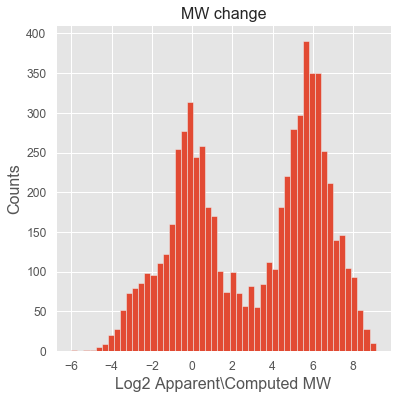

In [22]:
np.log2(ml_df['EF_MW_fc']).plot(kind='hist',figsize=(6,6), bins=50)
plt.title('MW change', fontsize=16)
plt.xlabel('Log2 Apparent\Computed MW',fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.savefig(os.path.join('figures','example_1','Fig_5.png'))
plt.show()

In [23]:
ml_df['EF_MW_fc'] = ml_df['EF_MW_fc'].fillna(0)

In [24]:
#extract second feature
#this extract the predicted protein complexes from the paper
temp = open(os.path.join('input', 'protein_complexes', 'final_complexes_mcp.txt'))
complex_set = []
for line in temp:
    prots = line.split('\t')
    prots = [n.strip() for n in prots]
    complex_set+=prots
complex_set=set(complex_set)
ml_df['EF_in_complex'] = [1 if n in complex_set else np.nan 
                          for n in ml_df['Gene ID']]
ml_df['EF_in_complex'].value_counts()
ml_df['EF_in_complex']=ml_df['EF_in_complex'].fillna(-1)

### Differentiation From BSF to PCF
Dejung M, 2016<p>
PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/26910529  ">26910529 </a> and <a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_1ec24003f1">TryTripDB</a>



During the life cycle of the African trypanosomes in the mammalian host, the trypanosomes undergo a developmental transition from a rapidly dividing long slender stage (LS) to a non-dividing short stumpy stage (SS). The LS stage is well adapted for growth in the mammalian host whereas the SS stage appears pre-adapted for life in the vector. In this dataset, parasites were induced to differentiate from the short stumpy (SS) form to the procyclic form (PF) using 6 mM citrate/cis-aconitate. Parasites were harvested at 0, 2, 4, 6, 12, 24, and 48 h after treatment, and established PF and long slender (LS) forms were also collected.

<b> The TriTrypDB dataset appears to miss the SS </b> (short stumpy stage) present in the original articles. See https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4765897/figure/ppat.1005439.g001/

In [25]:
#i'm going to code the LS stage as -1 hour and PF stage as +100 hour
#as they shuld represent the earliest and the latest time point in the series'
tryp_df.rename({'LS (tbru differ proteome)':
                 '-1 LS (tbru differ proteome)',
                 'PF (tbru differ proteome)':
                 '100 PF (tbru differ proteome)'},
                inplace=True,axis=1)
cols = [n for n in tryp_df.columns  if 'tbru differ proteome' in n]
cols

['-1 LS (tbru differ proteome)',
 '0 hr (tbru differ proteome)',
 '2 hr (tbru differ proteome)',
 '4 hr (tbru differ proteome)',
 '6 hr (tbru differ proteome)',
 '12 hr (tbru differ proteome)',
 '24 hr (tbru differ proteome)',
 '48 hr (tbru differ proteome)',
 '100 PF (tbru differ proteome)']

In [26]:
temp_df = tryp_df[cols]
temp_df = temp_df.replace(0.0, np.nan)
ml_df['EF_prot_BSF_to_PCF_1_min_max'] = np.log2(
    temp_df[cols].max(axis=1,skipna=True)/temp_df[cols].min(axis=1,skipna=True))
ml_df['EF_prot_BSF_to_PCF_1_max'] = temp_df[cols].idxmax(axis=1)
ml_df['EF_prot_BSF_to_PCF_1_max'] = [float(str(n).split(' ')[0]) 
                                     for n in ml_df['EF_prot_BSF_to_PCF_1_max']]
ml_df['EF_prot_BSF_to_PCF_1_min'] = temp_df[cols].idxmin(axis=1)
ml_df['EF_prot_BSF_to_PCF_1_min'] = [float(str(n).split(' ')[0]) 
                                     for n in ml_df['EF_prot_BSF_to_PCF_1_min']]

#ml_df['prot_BSF_to_PCF_1_min']=ml_df['prot_BSF_to_PCF_1_min'].astype('category')
#ml_df['prot_BSF_to_PCF_1_max']=ml_df['prot_BSF_to_PCF_1_max'].astype('category')

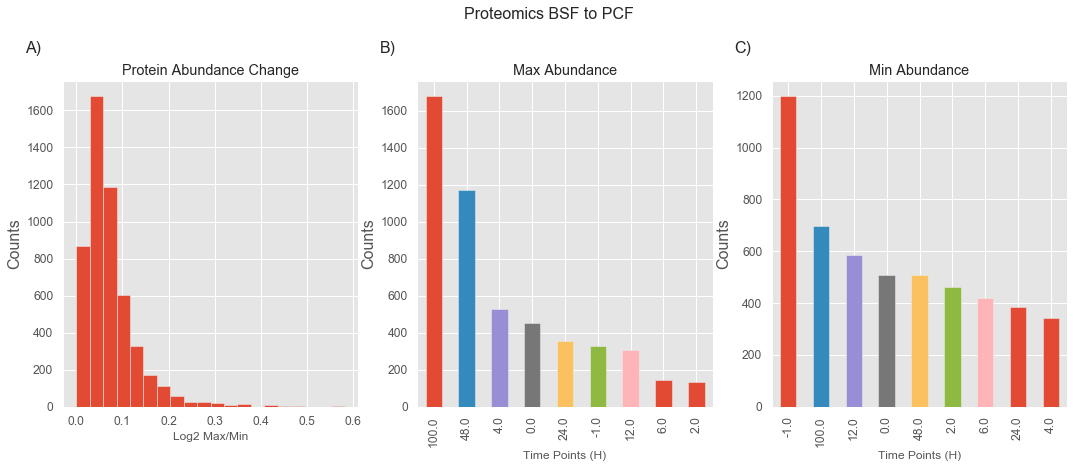

In [27]:
fig,axes=plt.subplots(figsize=(18,6),ncols=3)
ml_df['EF_prot_BSF_to_PCF_1_min_max'].plot(kind='hist', bins=20,ax=axes[0])
axes[0].set_xlabel('Log2 Max/Min',fontsize=12)
axes[0].set_ylabel('Counts', fontsize=16)
axes[0].set_title('Protein Abundance Change')
scripts.add_subplot_index(axes[0], text='A)')

ml_df['EF_prot_BSF_to_PCF_1_max'].value_counts().plot(kind='bar',ax=axes[1])
axes[1].set_xlabel('Time Points (H)',fontsize=12)
axes[1].set_ylabel('Counts', fontsize=16)
axes[1].set_title('Max Abundance')
scripts.add_subplot_index(axes[1], text='B)')

ml_df['EF_prot_BSF_to_PCF_1_min'].value_counts().plot(kind='bar',ax=axes[2])
axes[2].set_xlabel('Time Points (H)',fontsize=12)
axes[2].set_ylabel('Counts', fontsize=16)
axes[2].set_title('Min Abundance')
scripts.add_subplot_index(axes[2], text='C)')


plt.suptitle('Proteomics BSF to PCF',fontsize=16,y=1.05)
plt.savefig(os.path.join('figures','example_1','Fig_6.png'))
plt.show()

In [28]:
print(ml_df.shape)

(11832, 13)


## Processing of trascriptomics data

### microarray

#### DNA microarray BSF to PCF 1
<p>
Jensen BC et al, 2009

Differentiation from stumpy to tsetse-midgut procyclic forms
PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/19840382 ">19840382</a> and
<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_2e9f1cbf33">TryTripDB</a>

Whole genome comparison of RNA levels for both protein coding genes and structural RNAs in five different life-cycle stages: cultured bloodstream (Blood Form), in vivo slender bloodstream (Slender), in vivo stumpy bloodstream (Stumpy), log-phase procyclic culture (PCF Log) and stationary-phase procyclic culture forms (PCF Stat)   

In [29]:
tryp_df.rename({'Blood Form (Tb LifeCyc Marray)':
                '1 Blood Form (Tb LifeCyc Marray)',
                
                'Slender (Tb LifeCyc Marray)':
                 '2 Slender (Tb LifeCyc Marray)',

                'Stumpy (Tb LifeCyc Marray)':
                 '3 Stumpy (Tb LifeCyc Marray)',

                 'PCF Log (Tb LifeCyc Marray)':
                 '4 Stumpy (Tb LifeCyc Marray)',
                 
                'PCF Stat (Tb LifeCyc Marray)':
                 '5 PCF Stat (Tb LifeCyc Marray)',
                },
                inplace=True,axis=1)

cols = [n for n in tryp_df.columns  if 'Tb LifeCyc Marray' in n]
cols

['1 Blood Form (Tb LifeCyc Marray)',
 '2 Slender (Tb LifeCyc Marray)',
 '3 Stumpy (Tb LifeCyc Marray)',
 '4 Stumpy (Tb LifeCyc Marray)',
 '5 PCF Stat (Tb LifeCyc Marray)']

In [30]:
ml_df['EF_ma_BSF_to_PCF_1_min_max'] = np.log2(
    tryp_df[cols].max(axis=1,skipna=True)/tryp_df[cols].min(axis=1,skipna=True))
ml_df['EF_ma_BSF_to_PCF_1_max'] = tryp_df[cols].idxmax(axis=1)
ml_df['EF_ma_BSF_to_PCF_1_max'] = [float(str(n).split(' ')[0]) 
                                   for n in ml_df['EF_ma_BSF_to_PCF_1_max']]
ml_df['EF_ma_BSF_to_PCF_1_min'] = tryp_df[cols].idxmin(axis=1)
ml_df['EF_ma_BSF_to_PCF_1_min'] = [float(str(n).split(' ')[0]) 
                                   for n in ml_df['EF_ma_BSF_to_PCF_1_min']]

#ml_df['ma_BSF_to_PCF_1_max']=ml_df['ma_BSF_to_PCF_1_max'].astype('category')
#ml_df['ma_BSF_to_PCF_1_min']=ml_df['ma_BSF_to_PCF_1_min'].astype('category')

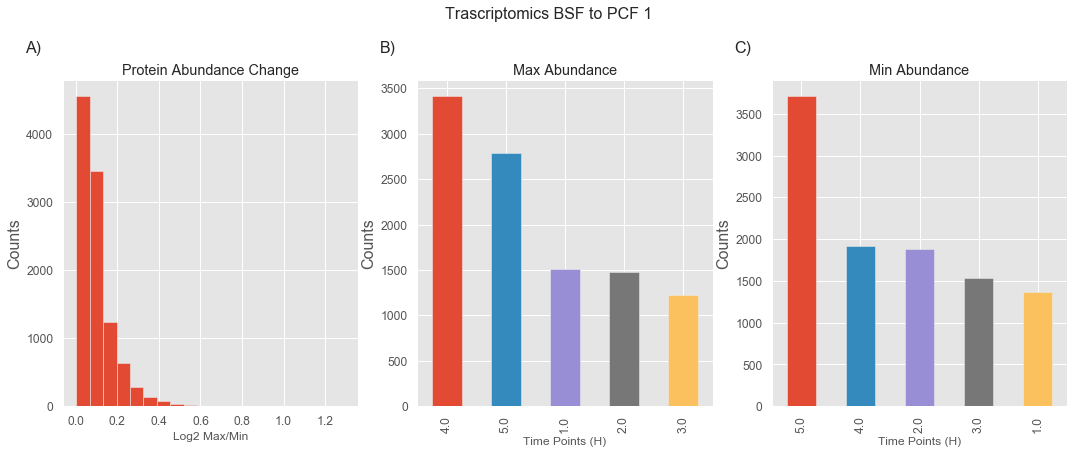

In [31]:
fig,axes=plt.subplots(figsize=(18,6),ncols=3)
ml_df['EF_ma_BSF_to_PCF_1_min_max'].plot(kind='hist', bins=20,ax=axes[0])
axes[0].set_xlabel('Log2 Max/Min',fontsize=12)
axes[0].set_ylabel('Counts', fontsize=16)
axes[0].set_title('Protein Abundance Change')
scripts.add_subplot_index(axes[0], text='A)')

ml_df['EF_ma_BSF_to_PCF_1_max'].value_counts().plot(kind='bar',ax=axes[1])
axes[1].set_xlabel('Time Points (H)',fontsize=12)
axes[1].set_ylabel('Counts', fontsize=16)
axes[1].set_title('Max Abundance')
scripts.add_subplot_index(axes[1], text='B)')

ml_df['EF_ma_BSF_to_PCF_1_min'].value_counts().plot(kind='bar',ax=axes[2])
axes[2].set_xlabel('Time Points (H)',fontsize=12)
axes[2].set_ylabel('Counts', fontsize=16)
axes[2].set_title('Min Abundance')
scripts.add_subplot_index(axes[2], text='C)')


plt.suptitle('Trascriptomics BSF to PCF 1',fontsize=16,y=1.05)
plt.savefig(os.path.join('figures','example_1','Fig_7.png'))
plt.show()

#### DNA microarray BSF to PCF 2
Queiroz R et al 2009<p>
Gene Expression profiling during in vitro differentiation from cultured bloodstream forms to procyclic forms
PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/19857263">19857263</a> and
<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_0c4be69d67">TryTripDB</a>

In [32]:
tryp_df.rename({'bf-ld (Tb cBSFtoPCF Marray)':
                 '-2 bf-ld (Tb cBSFtoPCF Marray)',
                'bf-hd (Tb cBSFtoPCF Marray)':
                 '-1 bf-hd (Tb cBSFtoPCF Marray)'
                },
                inplace=True,axis=1)

cols = [n for n in tryp_df.columns  if 'Tb cBSFtoPCF Marray' in n]
print (cols)

['-2 bf-ld (Tb cBSFtoPCF Marray)', '-1 bf-hd (Tb cBSFtoPCF Marray)', '0.5hr (Tb cBSFtoPCF Marray)', '1hr (Tb cBSFtoPCF Marray)', '12hr (Tb cBSFtoPCF Marray)', '24hr (Tb cBSFtoPCF Marray)', '48hr (Tb cBSFtoPCF Marray)', '72hr (Tb cBSFtoPCF Marray)']


In [33]:
ml_df['EF_ma_BSF_to_PCF_2_min_max'] = np.log2(
    np.exp(tryp_df[cols].max(axis=1,
                             skipna=True))/np.exp(tryp_df[cols].min(axis=1,
                                                                    skipna=True)))
ml_df['EF_ma_BSF_to_PCF_2_max'] = tryp_df[cols].idxmax(axis=1)
ml_df['EF_ma_BSF_to_PCF_2_max'] = [float(str(n).split(' ')[0].replace('hr','')) 
                                   for n in ml_df['EF_ma_BSF_to_PCF_2_max']]
ml_df['EF_ma_BSF_to_PCF_2_min'] = tryp_df[cols].idxmin(axis=1)
ml_df['EF_ma_BSF_to_PCF_2_min'] = [float(str(n).split(' ')[0].replace('hr','')) 
                                   for n in ml_df['EF_ma_BSF_to_PCF_2_min']]

#ml_df['ma_BSF_to_PCF_2_max']=ml_df['ma_BSF_to_PCF_2_max'].astype('category')
#ml_df['ma_BSF_to_PCF_2_min']=ml_df['ma_BSF_to_PCF_2_min'].astype('category')

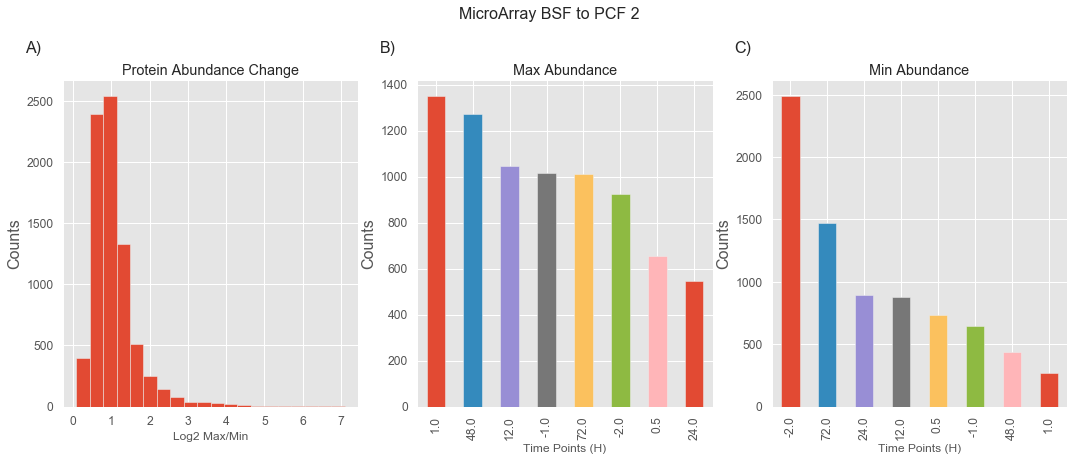

In [34]:
fig,axes=plt.subplots(figsize=(18,6),ncols=3)
ml_df['EF_ma_BSF_to_PCF_2_min_max'].plot(kind='hist', bins=20,ax=axes[0])
axes[0].set_xlabel('Log2 Max/Min',fontsize=12)
axes[0].set_ylabel('Counts', fontsize=16)
axes[0].set_title('Protein Abundance Change')
scripts.add_subplot_index(axes[0], text='A)')

ml_df['EF_ma_BSF_to_PCF_2_max'].value_counts().plot(kind='bar',ax=axes[1])
axes[1].set_xlabel('Time Points (H)',fontsize=12)
axes[1].set_ylabel('Counts', fontsize=16)
axes[1].set_title('Max Abundance')
scripts.add_subplot_index(axes[1], text='B)')

ml_df['EF_ma_BSF_to_PCF_2_min'].value_counts().plot(kind='bar',ax=axes[2])
axes[2].set_xlabel('Time Points (H)',fontsize=12)
axes[2].set_ylabel('Counts', fontsize=16)
axes[2].set_title('Min Abundance')
scripts.add_subplot_index(axes[2], text='C)')


plt.suptitle('MicroArray BSF to PCF 2',fontsize=16,y=1.05)
plt.savefig(os.path.join('figures','example_1','Fig_8.png'))
plt.show()

In [35]:
print(ml_df.shape)

(11832, 19)


#### DNA microarray BSF to PCF 3
Kabani et al.


PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/19747379 ">19747379</a> and
<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_b7dc54ebad">TryTripDB</a>

mRNA expression profiles of T. brucei AnTat1.1 slender and stumpy bloodstream stages, as well as 4 time points during the transition of the stumpy to the procyclic life-cycle stage

1. Slender bloodstream form: harvested 3 days post-infection of cyclophosphamide treated mice
2. 0 h time point (Stumpy bloodstream form): harvested 6 days post-infection of cyclophosphamide treated mice
3. 1 h time point: harvested 1 hour after initiating differentiation with cis-aconitate
4. 6 h time point: harvested 6 hour after initiating differentiation with cis-aconitate
5. 18 h time point: harvested 18 hour after initiating differentiation with cis-aconitate
6. 48 h time point: harvested 48 hour after initiating differentiation with cis-aconitate

In [36]:
#set the Slender as the erliest time point
tryp_df.rename({'Slender (Tb LifeCyc Diff Marray)':
                 '-1 Slender (Tb LifeCyc Diff Marray)'},
                inplace=True,axis=1)
cols = [n for n in tryp_df.columns  if 'Tb LifeCyc Diff Marray' in n]
cols

['-1 Slender (Tb LifeCyc Diff Marray)',
 '0 hr (Tb LifeCyc Diff Marray)',
 '1 hr (Tb LifeCyc Diff Marray)',
 '6 hr (Tb LifeCyc Diff Marray)',
 '18 hr (Tb LifeCyc Diff Marray)',
 '48 hr (Tb LifeCyc Diff Marray)']

In [37]:
ml_df['EF_ma_BSF_to_PCF_3_min_max'] = np.log2(
    tryp_df[cols].max(axis=1,skipna=True)/tryp_df[cols].min(axis=1,skipna=True))
ml_df['EF_ma_BSF_to_PCF_3_max'] = tryp_df[cols].idxmax(axis=1)
ml_df['EF_ma_BSF_to_PCF_3_max'] = [float(str(n).split(' ')[0]) 
                                   for n in ml_df['EF_ma_BSF_to_PCF_3_max']]
ml_df['EF_ma_BSF_to_PCF_3_min'] = tryp_df[cols].idxmin(axis=1)
ml_df['EF_ma_BSF_to_PCF_3_min'] = [float(str(n).split(' ')[0]) 
                                   for n in ml_df['EF_ma_BSF_to_PCF_3_min']]

#ml_df['ma_BSF_to_PCF_1_max']=ml_df['ma_BSF_to_PCF_1_max'].astype('category')
#ml_df['ma_BSF_to_PCF_1_min']=ml_df['ma_BSF_to_PCF_1_min'].astype('category')

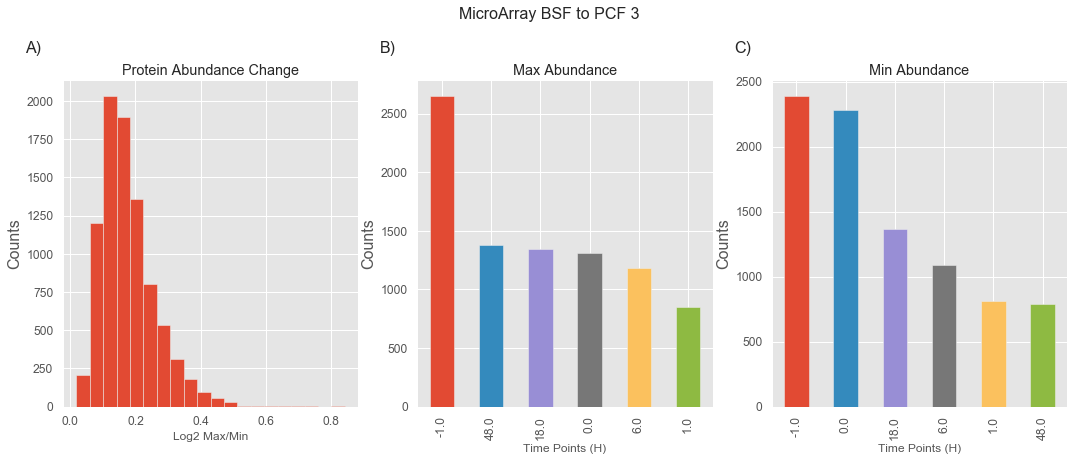

In [38]:
fig,axes=plt.subplots(figsize=(18,6),ncols=3)
ml_df['EF_ma_BSF_to_PCF_3_min_max'].plot(kind='hist', bins=20,ax=axes[0])
axes[0].set_xlabel('Log2 Max/Min',fontsize=12)
axes[0].set_ylabel('Counts', fontsize=16)
axes[0].set_title('Protein Abundance Change')
scripts.add_subplot_index(axes[0], text='A)')

ml_df['EF_ma_BSF_to_PCF_3_max'].value_counts().plot(kind='bar',ax=axes[1])
axes[1].set_xlabel('Time Points (H)',fontsize=12)
axes[1].set_ylabel('Counts', fontsize=16)
axes[1].set_title('Max Abundance')
scripts.add_subplot_index(axes[1], text='B)')

ml_df['EF_ma_BSF_to_PCF_3_min'].value_counts().plot(kind='bar',ax=axes[2])
axes[2].set_xlabel('Time Points (H)',fontsize=12)
axes[2].set_ylabel('Counts', fontsize=16)
axes[2].set_title('Min Abundance')
scripts.add_subplot_index(axes[2], text='C)')


plt.suptitle('MicroArray BSF to PCF 3',fontsize=16,y=1.05)
plt.savefig(os.path.join('figures','example_1','Fig_9.png'))
plt.show()

### RNA-Seq

#### RNA-Seq mouse blood vs gonadal fat
Trindade S, 2016<p>
Transcriptomes of T brucei parasites isolated from mouse blood and gonadal fat
PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/27237364 ">27237364</a> and
<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_917e265ce7">TryTripDB</a>

In [39]:
#average blood and fat replicates
cols_fat = [n for n in tryp_df.columns  if 'Tbru Adipose RNASeq' in n and 'Fat' in n]
cols_blood = [n for n in tryp_df.columns  if 'Tbru Adipose RNASeq' in n and 'Blood' in n]

tryp_df['fat_mean'] = tryp_df[cols_fat].mean(skipna=True, axis=1)
tryp_df['blood_mean'] = tryp_df[cols_blood].mean(skipna=True, axis=1)
print(tryp_df[['fat_mean','blood_mean']].shape)
#compute FC fat / blood 
ml_df['EF_RNASeq_adipose_blood']=np.log2(tryp_df['fat_mean'].replace(0,np.nan)/tryp_df['blood_mean'].replace(0,np.nan))

(11832, 2)


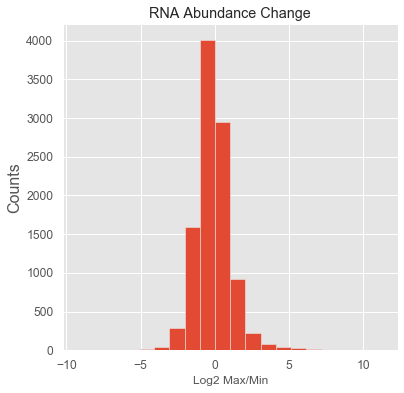

In [40]:
fig,ax=plt.subplots(figsize=(6,6))
ml_df['EF_RNASeq_adipose_blood'].plot(kind='hist', bins=20,ax=ax)
ax.set_xlabel('Log2 Max/Min',fontsize=12)
ax.set_ylabel('Counts', fontsize=16)
ax.set_title('RNA Abundance Change')
plt.savefig(os.path.join('figures','example_1','Fig_10.png'))
plt.show()

In [41]:
print(ml_df.shape)

(11832, 23)


#### RNA-Seq glucose response
Qiu Y, 2018<p>
RNA seq analysis with or without added glucose and proline/threonine
PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/30381351">30381351</a> and
<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_cf6d4532c7">TryTripDB</a>

In [42]:
#we used only the fold change in SS
temp_1 = tryp_df['sense - SS + gluc - unique only'].replace(0,np.nan)
temp_2 = tryp_df['sense - SS - gluc - unique only'].replace(0,np.nan)
ml_df['EF_fc_glucose_1'] = np.log2(temp_1/temp_2)

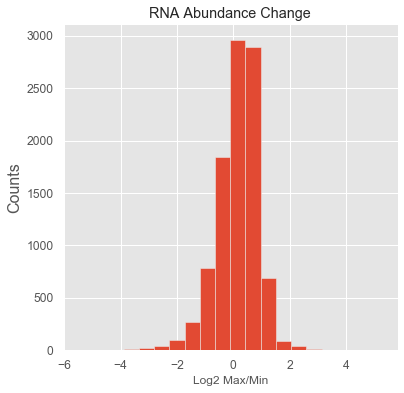

In [43]:
fig,ax=plt.subplots(figsize=(6,6))
ml_df['EF_fc_glucose_1'].plot(kind='hist', bins=20,ax=ax)
ax.set_xlabel('Log2 Max/Min',fontsize=12)
ax.set_ylabel('Counts', fontsize=16)
ax.set_title('RNA Abundance Change')
plt.savefig(os.path.join('figures','example_1','Fig_11.png'))
plt.show()

#### RNA-Seq cell cycle
Archer SK, 2016<p>
Gene expression profiling of the T. brucei cell cycle by RNA-sequencing
PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/21483801 ">21483801</a> and
<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_0de2f64330">TryTripDB</a>

In [44]:
cols = [n for n in tryp_df.columns if 'Tb CellCyc RSeq' in n]
#print (cols)
temp_df = tryp_df[cols]
temp_df = temp_df.replace(0.0, np.nan)
ml_df['EF_RNA_CellCycle_min_max'] = np.log2(
    temp_df[cols].max(axis=1,skipna=True)/temp_df[cols].min(axis=1,skipna=True))

temp_df.columns = [n.split(' - ')[2].split(' ')[0] for n in cols]
cols = temp_df.columns
ml_df['EF_RNA_CellCycle_max'] = temp_df[cols].idxmax(axis=1)
ml_df['EF_RNA_CellCycle_max'] = [float(n) for n in ml_df['EF_RNA_CellCycle_max']]
ml_df['EF_RNA_CellCycle_min'] = temp_df[cols].idxmin(axis=1)
ml_df['EF_RNA_CellCycle_min'] = [float(n) for n in ml_df['EF_RNA_CellCycle_min']] 

#ml_df['RNA_CellCycle_max']=ml_df['RNA_CellCycle_max'].astype('category')
#ml_df['RNA_CellCycle_min']=ml_df['RNA_CellCycle_min'].astype('category')

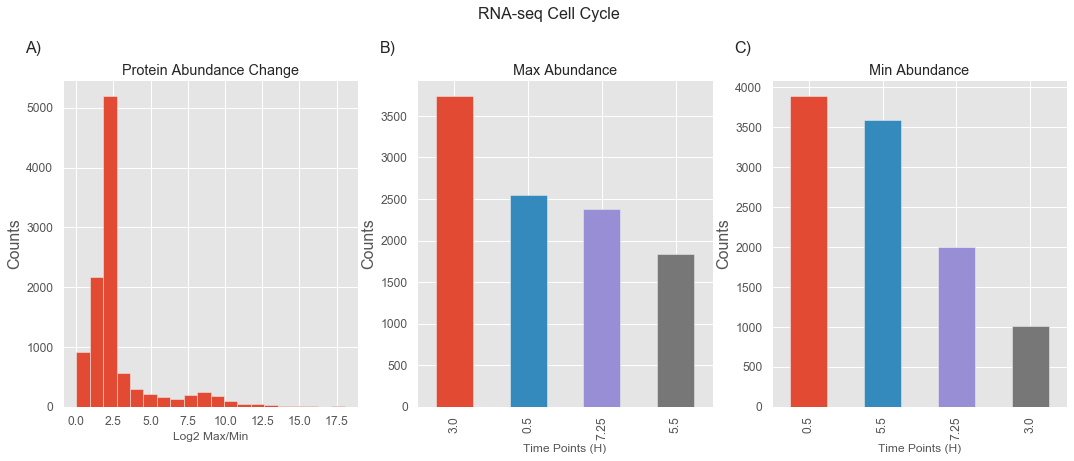

In [45]:
fig,axes=plt.subplots(figsize=(18,6),ncols=3)
ml_df['EF_RNA_CellCycle_min_max'].plot(kind='hist', bins=20,ax=axes[0])
axes[0].set_xlabel('Log2 Max/Min',fontsize=12)
axes[0].set_ylabel('Counts', fontsize=16)
axes[0].set_title('Protein Abundance Change')
scripts.add_subplot_index(axes[0], text='A)')

ml_df['EF_RNA_CellCycle_max'].value_counts().plot(kind='bar',ax=axes[1])
axes[1].set_xlabel('Time Points (H)',fontsize=12)
axes[1].set_ylabel('Counts', fontsize=16)
axes[1].set_title('Max Abundance')
scripts.add_subplot_index(axes[1], text='B)')

ml_df['EF_RNA_CellCycle_min'].value_counts().plot(kind='bar',ax=axes[2])
axes[2].set_xlabel('Time Points (H)',fontsize=12)
axes[2].set_ylabel('Counts', fontsize=16)
axes[2].set_title('Min Abundance')
scripts.add_subplot_index(axes[2], text='C)')

plt.suptitle('RNA-seq Cell Cycle',fontsize=16,y=1.05)
plt.savefig(os.path.join('figures','example_1','Fig_12.png'))
plt.show()

In [46]:
print(ml_df.shape)


(11832, 27)


#### RNA-seq BSF to PCF

Naguleswaran et al. 2018

PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/29606092">29606092</a> and 
<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_b5cbc0fe92">TryTripDB</a>

This study provides the first transcriptomic data from cultures of four consecutive life-cycle stages of Trypanosoma brucei.

In [47]:
tryp_df.rename({'antisense - Long Slender - unique only':
                 '1 antisense - Long Slender - unique only',
               
                'antisense - Short Stumpy - unique only':
                 '2 antisense - Short Stumpy - unique only',
                
                'antisense - PCF Early - unique only':
                 '3 antisense - PCF Early - unique only',

                 'antisense - PCF Late - unique only':
                 '4 antisense - PCF Late - unique only',

               },
                inplace=True,axis=1)

cols = ['1 antisense - Long Slender - unique only', 
        '2 antisense - Short Stumpy - unique only',
        '3 antisense - PCF Early - unique only',
        '4 antisense - PCF Late - unique only']


print (cols)
temp_df = tryp_df[cols]
temp_df = temp_df.replace(0.0, np.nan)
ml_df['EF_RNA_BSF_to_PCF_anti_min_max'] = np.log2(
    temp_df[cols].max(axis=1,skipna=True)/temp_df[cols].min(axis=1,skipna=True))

temp_df.columns = [n.split(' ')[0] for n in cols]
cols = temp_df.columns
ml_df['EF_RNA_BSF_to_PCF_anti_max'] = temp_df[cols].idxmax(axis=1)
ml_df['EF_RNA_BSF_to_PCF_anti_max'] = [float(n) for n 
                                       in ml_df['EF_RNA_BSF_to_PCF_anti_max']]
ml_df['EF_RNA_BSF_to_PCF_anti_min'] = temp_df[cols].idxmin(axis=1)
ml_df['EF_RNA_BSF_to_PCF_anti_min'] = [float(n) for n 
                                       in ml_df['EF_RNA_BSF_to_PCF_anti_min']] 

#ml_df['RNA_CellCycle_max']=ml_df['RNA_CellCycle_max'].astype('category')
#ml_df['RNA_CellCycle_min']=ml_df['RNA_CellCycle_min'].astype('category')

['1 antisense - Long Slender - unique only', '2 antisense - Short Stumpy - unique only', '3 antisense - PCF Early - unique only', '4 antisense - PCF Late - unique only']


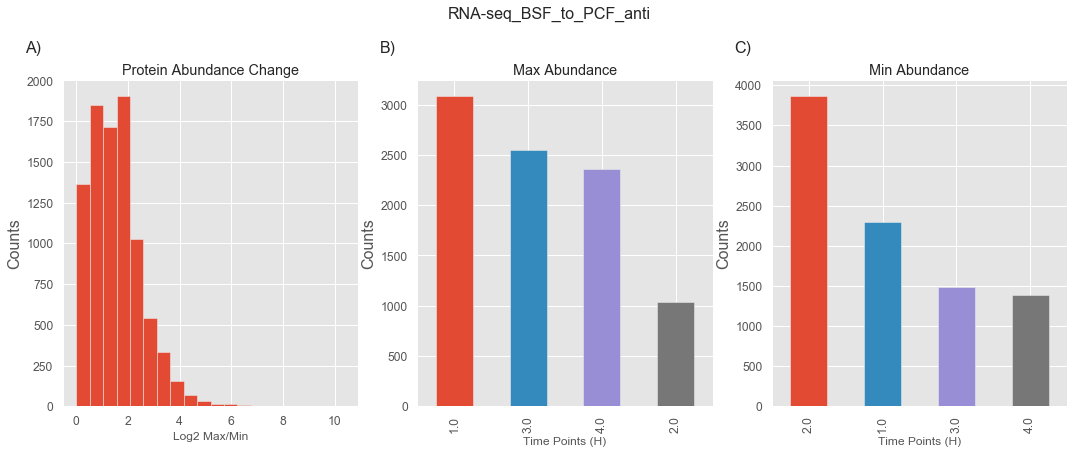

In [48]:
fig,axes=plt.subplots(figsize=(18,6),ncols=3)
ml_df['EF_RNA_BSF_to_PCF_anti_min_max'].plot(kind='hist', bins=20,ax=axes[0])
axes[0].set_xlabel('Log2 Max/Min',fontsize=12)
axes[0].set_ylabel('Counts', fontsize=16)
axes[0].set_title('Protein Abundance Change')
scripts.add_subplot_index(axes[0], text='A)')

ml_df['EF_RNA_BSF_to_PCF_anti_max'].value_counts().plot(kind='bar',ax=axes[1])
axes[1].set_xlabel('Time Points (H)',fontsize=12)
axes[1].set_ylabel('Counts', fontsize=16)
axes[1].set_title('Max Abundance')
scripts.add_subplot_index(axes[1], text='B)')

ml_df['EF_RNA_BSF_to_PCF_anti_min'].value_counts().plot(kind='bar',ax=axes[2])
axes[2].set_xlabel('Time Points (H)',fontsize=12)
axes[2].set_ylabel('Counts', fontsize=16)
axes[2].set_title('Min Abundance')
scripts.add_subplot_index(axes[2], text='C)')

plt.suptitle('RNA-seq_BSF_to_PCF_anti',fontsize=16,y=1.05)
plt.savefig(os.path.join('figures','example_1','Fig_13.png'))
plt.show()

In [49]:
tryp_df.rename({'sense - Long Slender - unique only':
                 '1 sense - Long Slender - unique only',
               
                'sense - Short Stumpy - unique only':
                 '2 sense - Short Stumpy - unique only',
                
                'sense - PCF Early - unique only':
                 '3 sense - PCF Early - unique only',

                 'sense - PCF Late - unique only':
                 '4 sense - PCF Late - unique only',

               },
                inplace=True,axis=1)

cols = ['1 sense - Long Slender - unique only', 
        '2 sense - Short Stumpy - unique only',
        '3 sense - PCF Early - unique only',
        '4 sense - PCF Late - unique only']



print (cols)
temp_df = tryp_df[cols]
temp_df = temp_df.replace(0.0, np.nan)
ml_df['EF_RNA_BSF_to_PCF_sen_min_max'] = np.log2(
    temp_df[cols].max(axis=1,skipna=True)/temp_df[cols].min(axis=1,skipna=True))

temp_df.columns = [n.split(' ')[0] for n in cols]
cols = temp_df.columns
ml_df['EF_RNA_BSF_to_PCF_sen_max'] = temp_df[cols].idxmax(axis=1)
ml_df['EF_RNA_BSF_to_PCF_sen_max'] = [float(n) for n 
                                      in ml_df['EF_RNA_BSF_to_PCF_sen_max']]
ml_df['EF_RNA_BSF_to_PCF_sen_min'] = temp_df[cols].idxmin(axis=1)
ml_df['EF_RNA_BSF_to_PCF_sen_min'] = [float(n) for n 
                                      in ml_df['EF_RNA_BSF_to_PCF_sen_min']] 


['1 sense - Long Slender - unique only', '2 sense - Short Stumpy - unique only', '3 sense - PCF Early - unique only', '4 sense - PCF Late - unique only']


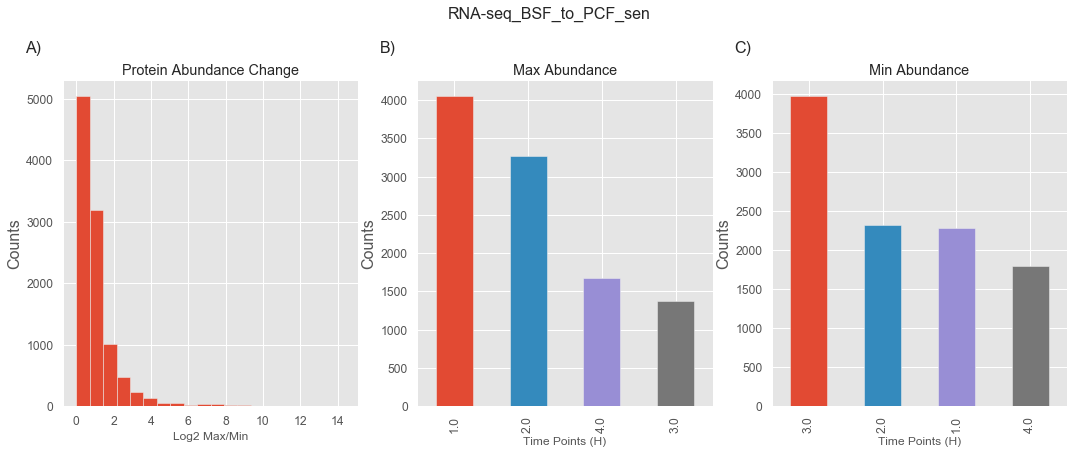

In [50]:
fig,axes=plt.subplots(figsize=(18,6),ncols=3)
ml_df['EF_RNA_BSF_to_PCF_sen_min_max'].plot(kind='hist', bins=20,ax=axes[0])
axes[0].set_xlabel('Log2 Max/Min',fontsize=12)
axes[0].set_ylabel('Counts', fontsize=16)
axes[0].set_title('Protein Abundance Change')
scripts.add_subplot_index(axes[0], text='A)')

ml_df['EF_RNA_BSF_to_PCF_sen_max'].value_counts().plot(kind='bar',ax=axes[1])
axes[1].set_xlabel('Time Points (H)',fontsize=12)
axes[1].set_ylabel('Counts', fontsize=16)
axes[1].set_title('Max Abundance')
scripts.add_subplot_index(axes[1], text='B)')

ml_df['EF_RNA_BSF_to_PCF_sen_min'].value_counts().plot(kind='bar',ax=axes[2])
axes[2].set_xlabel('Time Points (H)',fontsize=12)
axes[2].set_ylabel('Counts', fontsize=16)
axes[2].set_title('Min Abundance')
scripts.add_subplot_index(axes[2], text='C)')

plt.suptitle('RNA-seq_BSF_to_PCF_sen',fontsize=16,y=1.05)
plt.savefig(os.path.join('figures','example_1','Fig_14.png'))
plt.show()

#### RNA-Seq cyrcardian regulation
Rijo-Ferreira, 2017<p>
Bloodstream and procyclic form transcriptomes during a 48-hour time-course of alternating temperatures
PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/28288095 ">28288095</a> and 
<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_1cc46f3acb">TryTripDB</a>

In [51]:
# remove Rijo-Ferreira et al.columns, except for the result analysis
# of alternative temperature
keep = [
'BSF alt temp,period..ARSER - value (Tbruc BSF/PF Circadian RNAseq)',
'BSF alt temp,amplitude..ARSER - value (Tbruc BSF/PF Circadian RNAseq)',
'BSF alt temp,phase..ARSER - value (Tbruc BSF/PF Circadian RNAseq)',
#'BSF alt temp,pvalue..ARSER - value (Tbruc BSF/PF Circadian RNAseq)',
'PF alt temp,period..ARSER - value (Tbruc BSF/PF Circadian RNAseq)',
'PF alt temp,amplitude..ARSER - value (Tbruc BSF/PF Circadian RNAseq)',
'PF alt temp,phase..ARSER - value (Tbruc BSF/PF Circadian RNAseq)',
#'PF alt temp,pvalue..ARSER - value (Tbruc BSF/PF Circadian RNAseq)',       
]

new_names = [
'EF_BSF_period',
'EF_BSF_amplitude',
'EF_BSF_phase',
'EF_PF_period',
'EF_PF_amplitude',
'EF_PF_phase',      
]


ml_df[keep]=tryp_df[keep].copy()
ml_df[keep]=ml_df[keep].fillna(-1)
rename = dict(zip(keep,new_names))
ml_df.rename(rename,axis=1, inplace=True)


In [52]:
ml_df.head()

,Gene ID,EF_merged_PCF_BSF,SS (Tb927 LSvSS QProt),EF_CellCycle_min_max,EF_CellCycle_max,EF_CellCycle_min,EF_Abundance_BSF,EF_Abundance_PCF,EF_MW_fc,EF_in_complex,...,EF_RNA_BSF_to_PCF_anti_min,EF_RNA_BSF_to_PCF_sen_min_max,EF_RNA_BSF_to_PCF_sen_max,EF_RNA_BSF_to_PCF_sen_min,EF_BSF_period,EF_BSF_amplitude,EF_BSF_phase,EF_PF_period,EF_PF_amplitude,EF_PF_phase
0,Tb04.24M18.150,0.402849,NaN,0.000000,0.5,0.5,5.870638,7.631146,229.805303,-1.0,...,NaN,0.640412,2.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,Tb04.3I12.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-1.0,...,4.0,2.586469,2.0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,Tb05.30F7.410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-1.0,...,2.0,3.906891,1.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,Tb05.5K5.10,NaN,NaN,NaN,NaN,NaN,7.606765,7.829130,0.000000,-1.0,...,NaN,0.000000,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,Tb05.5K5.100,NaN,NaN,0.263034,11.0,10.0,6.758570,7.772565,20.888992,-1.0,...,NaN,0.299290,1.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


#### RNA-Seq Abundance
Vasquez JJ, 2014<p>
Procyclic and bloodstream form mRNA transcriptome and ribosome profiling
PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/24442674 ">24442674</a> and
<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_7252b6506e">TryTripDB</a>

In [53]:
#abundace
cols = ['sense - PF mRNA', 
            'sense - PF RiboProfile', 
            'sense - BF mRNA',
            'sense - BF RiboProfile',
            ]
new_names = [
'EF_sense_PF_mRNA',
'EF_sense_PF_RiboProfile',
'EF_sense_BF_mRNA',
'EF_sense_BF_RiboProfile',     
]
temp= tryp_df[cols]
temp= np.log10(temp[cols].replace(0,np.nan))
ml_df[cols]=temp

rename = dict(zip(cols,new_names))
ml_df.rename(rename,axis=1, inplace=True)
ml_df.shape

(11832, 43)

In [54]:
#differential abundace
cols = ['sense - PF mRNA', 
            'sense - PF RiboProfile', 
            'sense - BF mRNA',
            'sense - BF RiboProfile',
            ]
temp= tryp_df[cols]
temp= temp[cols].replace(0,np.nan)
temp['mRNA_BSF_vs_PCF'] = np.log2(temp['sense - BF mRNA']/
                                  temp['sense - PF mRNA'])
temp['RiboP_BSF_vs_PCF'] = np.log2(temp['sense - BF RiboProfile']/
                                   temp['sense - PF RiboProfile'])
ml_df[['EF_mRNA_BSF_vs_PCF',
       'EF_RiboP_BSF_vs_PCF']]=temp[['mRNA_BSF_vs_PCF',
                                     'RiboP_BSF_vs_PCF']]
del temp
gc.collect()
ml_df.shape

(11832, 45)

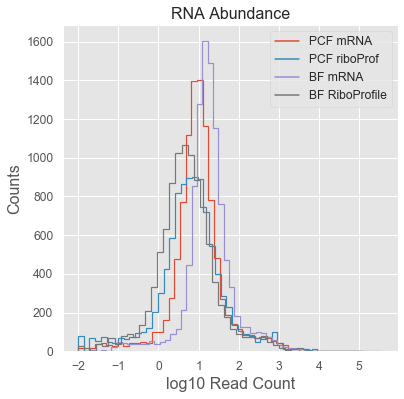

In [55]:
fig,ax=plt.subplots(figsize=(6,6))
from matplotlib.lines import Line2D
ml_df['EF_sense_PF_mRNA'].plot(kind='hist',histtype='step', 
                               ax=ax, label='PCF mRNA',linewidth=1.2,bins=50)
ml_df['EF_sense_PF_RiboProfile'].plot(kind='hist',histtype='step',
                                      ax=ax, label='PCF riboProf',
                                      linewidth=1.2,bins=50)
ml_df['EF_sense_BF_mRNA'].plot(kind='hist',histtype='step', ax=ax,
                               label='BF mRNA',linewidth=1.2,bins=50)
ml_df['EF_sense_BF_RiboProfile'].plot(kind='hist',histtype='step', 
                                      ax=ax, label='BF RiboProfile',
                                      linewidth=1.2,bins=50)

plt.xlabel('log10 Read Count', fontsize=16)
plt.ylabel('Counts', fontsize=16)
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
plt.legend(handles=new_handles, labels=labels)
plt.title('RNA Abundance',fontsize=16)
plt.savefig(os.path.join('figures','example_1','Fig_15.png'))
plt.show()

In [56]:
import numpy as np
np.log2(10e7)

26.575424759098897

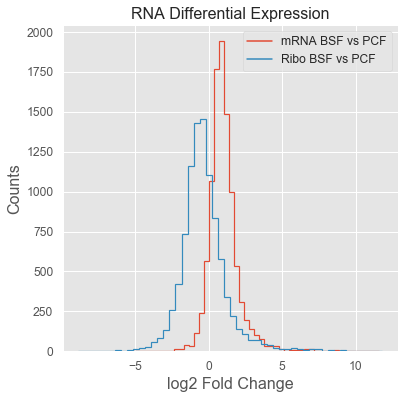

In [57]:
fig,ax=plt.subplots(figsize=(6,6))
from matplotlib.lines import Line2D
ml_df['EF_mRNA_BSF_vs_PCF'].plot(kind='hist',histtype='step', 
                                 ax=ax, label='mRNA BSF vs PCF',
                                 linewidth=1.2,bins=50)
ml_df['EF_RiboP_BSF_vs_PCF'].plot(kind='hist',histtype='step',
                                  ax=ax, label='Ribo BSF vs PCF',
                                  linewidth=1.2,bins=50)
plt.xlabel('log2 Fold Change', fontsize=16)
plt.ylabel('Counts', fontsize=16)
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
plt.legend(handles=new_handles, labels=labels)
plt.title('RNA Differential Expression',fontsize=16)
plt.savefig(os.path.join('figures','example_1','Fig_16.png'))
plt.show()


#### RNA-Seq phenotyping
Alsford S, 2011<p>
High-throughput phenotyping using parallel sequencing of RNA interference targets in the African trypanosome
PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/21363968">21363968</a> and
<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/dataset/DS_3f5188c7a8">TryTripDB</a>

The experiment with tags BFd6/Tet-,  PF/Tet-, difn/Tet- contain a mixture of numbers and numbers followed by an asterisks. Don't know why but can't included for now.

In [58]:
col = 'BFd3/Tet- (CDS only)'
ml_df['EF_'+col.split('/')[0]]=np.log2(tryp_df[col].replace(0,np.nan))

cols = ['BFd3/Tet- (CDS only)','BFd6/Tet- (CDS only)',
        'PF/Tet- (CDS only)','difn/Tet- (CDS only)']
for col in cols:
    print(col)
    ml_df['EF_'+col.split('/')[0]]=np.log2(tryp_df[col].replace(0,np.nan))

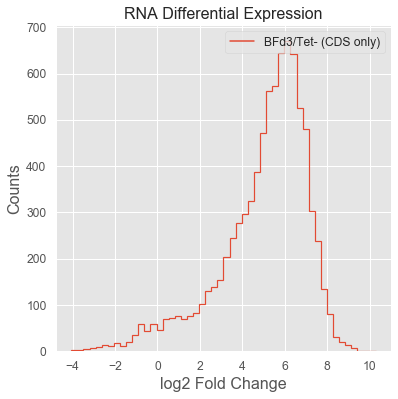

In [59]:
fig,ax=plt.subplots(figsize=(6,6))
from matplotlib.lines import Line2D
ml_df['EF_'+col.split('/')[0]].plot(kind='hist',histtype='step', 
                                        ax=ax, label=col,linewidth=1.2,bins=50)

plt.xlabel('log2 Fold Change', fontsize=16)
plt.ylabel('Counts', fontsize=16)
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
plt.legend(handles=new_handles, labels=labels)
plt.title('RNA Differential Expression',fontsize=16)
plt.savefig(os.path.join('figures','example_1','Fig_17.png'))
plt.show()

### More Computed Features out of creativity

### Signal Peptide

In [60]:
#processing of the signal peptide data
from sklearn.preprocessing import minmax_scale
def parse_signal_ip(X):
    if str(X).strip() != str(np.nan):
        temp = [n.strip() for n in X.split(', ')]
        score_a = float(temp[0].split(':')[1].strip())
        score_b = float(temp[1].split(':')[1].strip())   
        score_c = float(temp[2].split(':')[1].strip())
        return score_a,score_b,score_c
    else:
        return 0, 0, 0
temp = pd.DataFrame()
temp["sig_a"], temp["sig_b"], temp["sig_c"] = zip(*tryp_df['SignalP Scores'].apply(
    lambda val: parse_signal_ip(val)))
temp = pd.DataFrame(minmax_scale(temp.values, feature_range =(0,1) ),
                    columns =["sig_a","sig_b","sig_b"], index=temp.index)
ml_df['sig_pep']=temp.sum(axis=1)

In [61]:
ml_df.shape

(11832, 47)

### Distance from thelomer and position in the polycistronic transcript

In [62]:
#read the gff file and process    
infile=os.path.join('input','TriTrypDB-43_TbruceiTREU927.gff')
source_size = get_source_size(infile=infile)
count=count_comment_line(infile=infile)
gff = pd.read_table(infile,skiprows=count,header=None)
columns = ['seqname','source','feature','start','end',
           'score','strand','frame','attribute']
gff.columns = columns
gff=gff[gff.feature=='gene']
gff['gene_id']=[get_attributes(n)['ID'] for n in gff.attribute]
gff.drop(['attribute','score','frame','source','feature'],inplace=True,axis=1)


gff.sort_values(['seqname','start'],inplace=True)
gff['cds_middle']=(gff['start']+gff['end'])/2
gff['cds_middle']=gff['cds_middle'].astype(int)
gff['cds_lenght']=gff['end']-gff['start']
gff['norm_pos']=[float(a)/source_size[b] for a,b in zip(gff.cds_middle,gff.seqname)]

#shift the dataframe to capture when the genes change plolycistron
gff['strand_shift'] = gff.strand.shift(1)
gff['change']=gff['strand_shift']==gff['strand']

polycistronic_id = []
count=0
for a,b in zip(gff.seqname, gff.change):
    if b:
        polycistronic_id.append(count)
    else:
        polycistronic_id.append(count+1)
        count+=1
gff['polycistron_id'] = [a+'_'+str(b) for a,b in zip(gff.seqname, polycistronic_id)]
temp_g = gff.groupby(['polycistron_id'])
temp_g = temp_g['start'].max()-temp_g['start'].min()
polycistron_sizes = temp_g.to_dict()
gff['polycistron_size']=[polycistron_sizes[n] for n in gff['polycistron_id']]
temp_g = gff.groupby(['polycistron_id'])
gff['polycistron_cds_start']=temp_g['cds_lenght'].cumsum()
gff['polycistron_norm_pos']=gff['polycistron_cds_start']/gff['polycistron_size']
#gff['polycistron_size']=
gff.drop_duplicates(subset=['gene_id'],inplace=True)
gff.set_index('gene_id',inplace=True)
gff[1000:2000].head(10)

,seqname,start,end,strand,cds_middle,cds_lenght,norm_pos,strand_shift,change,polycistron_id,polycistron_size,polycistron_cds_start,polycistron_norm_pos
gene_id,,,,,,,,,,,,,
Tb927.3.1930,Tb927_03_v5.1,508299,509783,-,509041,1484,0.307908,-,True,Tb927_03_v5.1_65,196568,96120,0.488991
Tb927.3.1940,Tb927_03_v5.1,510641,511970,-,511305,1329,0.309277,-,True,Tb927_03_v5.1_65,196568,97449,0.495752
Tb927.3.1955,Tb927_03_v5.1,513487,514034,-,513760,547,0.310762,-,True,Tb927_03_v5.1_65,196568,97996,0.498535
Tb927.3.1960,Tb927_03_v5.1,514271,515762,-,515016,1491,0.311522,-,True,Tb927_03_v5.1_65,196568,99487,0.506120
Tb927.3.1970,Tb927_03_v5.1,516166,517317,-,516741,1151,0.312565,-,True,Tb927_03_v5.1_65,196568,100638,0.511975
Tb927.3.1980,Tb927_03_v5.1,517473,518492,-,517982,1019,0.313316,-,True,Tb927_03_v5.1_65,196568,101657,0.517159
Tb927.3.1990,Tb927_03_v5.1,518617,520892,-,519754,2275,0.314388,-,True,Tb927_03_v5.1_65,196568,103932,0.528733
Tb927.3.2000,Tb927_03_v5.1,521498,522203,-,521850,705,0.315656,-,True,Tb927_03_v5.1_65,196568,104637,0.532320
Tb927.3.2010,Tb927_03_v5.1,522343,524255,-,523299,1912,0.316532,-,True,Tb927_03_v5.1_65,196568,106549,0.542047


In [63]:
#add the new features
print(ml_df.shape)
ml_df=ml_df.join(gff[['norm_pos', 'polycistron_cds_start',
                      'polycistron_norm_pos']], how='left', on='Gene ID')
print(ml_df.shape)

(11832, 47)
(11832, 50)


In [64]:
#tryp_df['# TM Domains']

In [65]:
#Anoter normalization of the SNPs data
temp_1 = tryp_df['NonSynonymous SNPs All Strains']
temp_2 = tryp_df['Transcript Length']
ml_df['my_snp_1']=temp_1/temp_2

#Anoter normalization for the trans-membrane domain
ml_df['tm_1']=tryp_df['# TM Domains']/tryp_df['Transcript Length']
ml_df['Transcript Length'] = np.log(tryp_df['Transcript Length'])

### More feature from TritrypDB 

The next columns / sequence features do not need preprocessing, we just transfer these features to our ML dataset

In [66]:
cols =[
    #experiment features
    
    'DEAD:DQAD mutant - DHH1 mutant induced vs control (Tb427 DHH1 induced)',
    'heatShock_vs_control (heat shock treated)',
    'wild type - wild type induced vs control (Tb427 DHH1 induced)',
    'Nuclear Enriched Sample (Tb927 Nuc Prot)',

    #sequence features
    'Ortholog count',
    'Paralog count',
    'Non-Coding SNPs All Strains',
    'NonSyn/Syn SNP Ratio All Strains', 
    'NonSynonymous SNPs All Strains', 
    'SNPs with Stop Codons All Strains', 
    'Synonymous SNPs All Strains', 
    'Total SNPs All Strains']


rename = {
    'DEAD:DQAD mutant - DHH1 mutant induced vs control (Tb427 DHH1 induced)':
    'EF_DHH1_mutant',
    
    'heatShock_vs_control (heat shock treated)':
    'EF_heatShock',
    
    'wild type - wild type induced vs control (Tb427 DHH1 induced)':
    'EF_DHH1_induced',
    
    'LS (Tb927 LSvSS QProt)':'EF_LS_QProt',
    'SS (Tb927 LSvSS QProt)':'EF_SS_QProt',
    
    'Nuclear Enriched Sample (Tb927 Nuc Prot)':
    'EF_Nuclear_enriched',}


ml_df[cols]=tryp_df[cols]
ml_df.rename(rename, axis=1, inplace=True)

ml_df.shape

(11832, 65)

In [67]:
ml_df.head()

,Gene ID,EF_merged_PCF_BSF,EF_SS_QProt,EF_CellCycle_min_max,EF_CellCycle_max,EF_CellCycle_min,EF_Abundance_BSF,EF_Abundance_PCF,EF_MW_fc,EF_in_complex,...,EF_DHH1_induced,EF_Nuclear_enriched,Ortholog count,Paralog count,Non-Coding SNPs All Strains,NonSyn/Syn SNP Ratio All Strains,NonSynonymous SNPs All Strains,SNPs with Stop Codons All Strains,Synonymous SNPs All Strains,Total SNPs All Strains
0,Tb04.24M18.150,0.402849,NaN,0.000000,0.5,0.5,5.870638,7.631146,229.805303,-1.0,...,-0.12,NaN,57,1,0,3.40,17,0,5,22
1,Tb04.3I12.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-1.0,...,NaN,NaN,0,0,1,2.13,17,1,8,27
2,Tb05.30F7.410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-1.0,...,NaN,NaN,0,0,96,7.00,7,0,1,104
3,Tb05.5K5.10,NaN,NaN,NaN,NaN,NaN,7.606765,7.829130,0.000000,-1.0,...,NaN,NaN,43,1,0,0.00,0,0,0,0
4,Tb05.5K5.100,NaN,NaN,0.263034,11.0,10.0,6.758570,7.772565,20.888992,-1.0,...,0.07,NaN,7,1,0,1.00,1,0,1,2


In [68]:
#[n for n in ml_df.columns if 'heatShock' in n]

### Coding transcripts

In [69]:
#adding binary value, protein coding or not
def get_prop(desc):
    desc=desc.split('|')
    desc = [n.strip().split('=') for n in desc][1:]
    desc = dict(zip([n[0] for n in desc],[n[1] for n in desc]))
    return(desc['gene'])
      
infile=os.path.join('input','TriTrypDB-43_TbruceiTREU927_AnnotatedProteins.fasta')
handle = open(infile, "rU")
prot_cod = []
for record in SeqIO.parse(handle, "fasta"):
    #print(record.id)
    prot_cod.append(get_prop(record.description))
prot_cod=set(prot_cod)  
ml_df['prot_coding']=[1 if n in prot_cod else 0 for n in ml_df['Gene ID']]
ml_df['prot_coding'].value_counts()

1    11203
0      629
Name: prot_coding, dtype: int64

## Sequence Based Features
We now add several features from the protein sequence, pre-computed with the package Profet (https://github.com/ddofer/ProFET)


In [70]:
def prepare_profet(infile=os.path.join('input','profet.zip')):
    df = pd.read_csv(infile)
    df['Gene ID'] = [clean_id(n) for n in df['protein']]
    df.drop_duplicates(subset=['Gene ID'],inplace=True)
    df.set_index('Gene ID',inplace=True,drop=True)
    del df['protein']
    #we now remove sequence features with high correlation
    df_corr = df.corr().abs()
    upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
    df.drop(to_drop,axis=1,inplace=True)
    return df


temp =  prepare_profet()
#already present in the output of TriTrypDB
del temp['Molecular Weight']
#final_df.drop(temp.columns,axis=1,inplace=True)
print(ml_df.shape)
ml_df=ml_df.join(temp, how='left', on='Gene ID')
print(ml_df.shape)

(11832, 66)
(11832, 1125)


### ELM linear motif
We now extract and counts the number of linear motif found in the protein sequences using the ELM database (http://elm.eu.org/), Last modified on: Aug. 21, 2019

In [71]:
import re

def find_motif(prot,motif):
    return len(motif.findall(prot))

infile=os.path.join('input', 'elm_classes.tsv')
count=count_comment_line(infile=infile, tag='#')
elm = pd.read_table(infile,skiprows=count)
elm.head()
elm_dict = {}
for r,s in zip(elm.ELMIdentifier, elm.Regex):
    elm_dict[r]=re.compile(s)

motif_dict={}
infile=os.path.join('input','TriTrypDB-43_TbruceiTREU927_AnnotatedProteins.fasta')
handle = open(infile, "rU")    
for record in SeqIO.parse(handle, "fasta"):
    temp_id = clean_id (record.id)
    seq = str(record.seq)
    res = [find_motif(seq, motif) for motif in elm_dict.values()]
    #print (res)
    motif_dict[temp_id]=res

motif_dict = pd.DataFrame.from_dict(motif_dict,orient='index')           
motif_dict.head()
motif_dict.columns = elm_dict.keys()

motif_dict['ELM_CLV'] = motif_dict[
    [n for n in motif_dict.columns if n.startswith('CLV')]].sum(axis=1)
motif_dict['ELM_DEG'] = motif_dict[
    [n for n in motif_dict.columns if n.startswith('DEG')]].sum(axis=1)
motif_dict['ELM_DOC'] = motif_dict[
    [n for n in motif_dict.columns if n.startswith('DOC')]].sum(axis=1)
motif_dict['ELM_LIG'] = motif_dict[
    [n for n in motif_dict.columns if n.startswith('LIG')]].sum(axis=1)
motif_dict['ELM_MOD'] = motif_dict[
    [n for n in motif_dict.columns if n.startswith('MOD')]].sum(axis=1)
motif_dict['ELM_TRG'] = motif_dict[
    [n for n in motif_dict.columns if n.startswith('TRG')]].sum(axis=1)
motif_dict.head()

,CLV_C14_Caspase3-7,CLV_MEL_PAP_1,CLV_NRD_NRD_1,CLV_PCSK_FUR_1,CLV_PCSK_KEX2_1,CLV_PCSK_PC1ET2_1,CLV_PCSK_PC7_1,CLV_PCSK_SKI1_1,CLV_Separin_Fungi,CLV_Separin_Metazoa,...,TRG_NLS_MonoExtN_4,TRG_Pf-PMV_PEXEL_1,TRG_PTS1,TRG_PTS2,ELM_CLV,ELM_DEG,ELM_DOC,ELM_LIG,ELM_MOD,ELM_TRG
Tb927.1.05,4,0,3,0,2,1,0,5,0,0,...,1,1,0,0,15,1,14,37,58,3
Tb927.1.1000,2,0,1,0,3,2,0,11,0,0,...,0,0,0,0,19,2,15,53,42,9
Tb927.1.100,0,0,6,1,3,0,1,7,0,2,...,0,1,0,0,20,3,20,69,57,16
Tb927.1.1010,3,0,4,1,4,2,1,13,0,0,...,0,1,0,0,28,3,39,94,88,10
Tb927.1.1020,2,0,1,0,1,0,0,4,0,1,...,0,1,0,0,9,1,11,57,54,9


In [72]:
#add the features
print(ml_df.shape)
ml_df=ml_df.join(motif_dict, how='left', on='Gene ID')
print(ml_df.shape)

(11832, 1125)
(11832, 1410)


### Finalize dataset

In [73]:
ml_df.head()
ml_df = scripts.reduce_mem_usage(ml_df)

Memory usage of dataframe is 127.28 MB



Memory usage after optimization is: 64.00 MB
Decreased by 49.7%


In [74]:
ml_df=ml_df.drop_duplicates('Gene ID')

#save for later
ml_df.to_csv(os.path.join('output','final_df.gz'), compression='gzip',)

In [75]:
#uncomment if you start from here
#ml_df=pd.read_csv(os.path.join('output','final_df.gz'))
#ml_df.head()

In [76]:
#ml_df.head()

In [77]:
0.22179513 - (0.22179513 * 10)

-1.9961561700000001

## Modelling of protein stability

In our recent paper (Tinti, Guther et al. 2019) we used SILAC based mass spectrometry analysis to reveal the synthesis and degradation profiles for thousands of proteins in the bloodstream and procyclic forms of T. brucei. From this dataset we defined a group of stable (slow turnover) and unstable (fast turnover) proteins in the BSF life stage. To achieve this, the half-life values of the proteins fitted with an exponential decay model in BSF were divided into 10 quantiles (1 to 10). The first two quantiles (1 and 2) are used here to select the fast turnover protein while the last two quantiles (9 and10) are used here to select the slow turnover proteins.

In [78]:
turnover_bsf = pd.read_csv(os.path.join('input','turnover','Table_S2.zip'), 
                           index_col=[0], dtype={'bins':str})
turnover_bsf = turnover_bsf[turnover_bsf['used_for_analysis']==1]
#print('bin','size')
#print(turnover_bsf['bins'].value_counts())
fast = list(turnover_bsf[(turnover_bsf['bins']=='1') | (turnover_bsf['bins']=='2')].index.values) #| (turnover_bsf['bins']=='2.0')].index.values
slow = list(turnover_bsf[(turnover_bsf['bins']=='10') | (turnover_bsf['bins']=='9') ].index.values)# | (turnover_bsf['bins']=='10.0')].index.values
print('Fast:',len(fast),'Slow:',len(slow))
target_dict ={}
for n in fast:
    target_dict[n]=1
for n in slow:
    target_dict[n]=0

Fast: 837 Slow: 837


In [79]:
ml_df['target']=[target_dict.get(n,np.nan) for n in ml_df['Gene ID']]


In [80]:
X = ml_df.dropna(subset=['target'])
X.head()

,Gene ID,EF_merged_PCF_BSF,EF_SS_QProt,EF_CellCycle_min_max,EF_CellCycle_max,EF_CellCycle_min,EF_Abundance_BSF,EF_Abundance_PCF,EF_MW_fc,EF_in_complex,...,TRG_Pf-PMV_PEXEL_1,TRG_PTS1,TRG_PTS2,ELM_CLV,ELM_DEG,ELM_DOC,ELM_LIG,ELM_MOD,ELM_TRG,target
16,Tb05.5K5.210,-1.994036,NaN,NaN,NaN,NaN,8.097232,NaN,0.000000,-1.0,...,4.0,0.0,0.0,25.0,3.0,24.0,101.0,129.0,17.0,1.0
123,Tb09.v4.0015,NaN,NaN,0.263034,8.0,0.5,7.749779,6.103549,165.901093,-1.0,...,0.0,0.0,0.0,12.0,1.0,21.0,25.0,33.0,9.0,1.0
627,Tb11.02.5070b,NaN,NaN,0.137504,3.0,0.5,7.300305,7.716082,129.376068,-1.0,...,1.0,0.0,0.0,15.0,2.0,12.0,35.0,31.0,2.0,1.0
908,Tb11.v5.0154,NaN,NaN,0.000000,0.5,0.5,7.911051,7.178399,46.476665,-1.0,...,0.0,0.0,0.0,19.0,3.0,21.0,70.0,80.0,5.0,0.0
945,Tb11.v5.0191,NaN,NaN,0.263034,0.5,3.0,6.970981,6.841282,90.802986,-1.0,...,1.0,0.0,0.0,26.0,4.0,18.0,56.0,57.0,10.0,1.0


In [81]:
X=X.dropna(axis=0, how='all')
X=X.dropna(axis=1, how='all')

In [82]:
y=X['target']
del X['target']
del X['Gene ID']
del  X['prot_coding']
print(X.shape,y.shape)
y.value_counts()

(1674, 1407) (1674,)


0.0    837
1.0    837
Name: target, dtype: int64

In [83]:
# very crude removal of high correlated features
# Create correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
print('Removing:',len(to_drop), 'features')

Removing: 277 features


In [84]:
print(X.shape)
X=X.drop(to_drop, axis=1)
print(X.shape)

(1674, 1407)
(1674, 1130)


In [85]:
#Strategy to input missing values / optional but usefull for 
#visualization of the feature importance
X = scripts.input_missing_values(X, X.columns)

### First Train

DataSet size
X_train: (1088, 1130) X_test: (586, 1130) y_train: (1088,) y_test (586,)


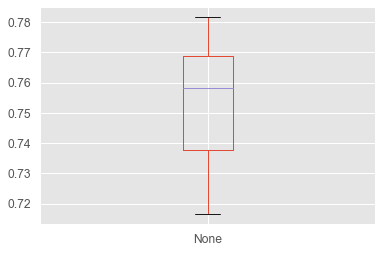

              precision    recall  f1-score   support

         0.0       0.60      0.69      0.64       258
         1.0       0.72      0.64      0.68       328

    accuracy                           0.66       586
   macro avg       0.66      0.66      0.66       586
weighted avg       0.67      0.66      0.66       586

1 dummy_roc_auc_score: 0.5137232059645853
1 blind_roc_auc_score: 0.6635588012856872

Confusion Matrix
[[178  80]
 [119 209]]


{'objective': 'binary',
 'min_data_in_leaf': 5,
 'n_jobs': 8,
 'boosting_type': 'rf',
 'bagging_fraction': 0.7,
 'feature_fraction': 0.7,
 'bagging_freq': 1,
 'n_estimators': 9,
 'max_depth': 5}

In [86]:
params = {
            'objective': 'binary',
            'min_data_in_leaf':5,
            'n_jobs':8,
            'boosting_type':"rf",
            'bagging_fraction':0.7,
            'feature_fraction':0.7,
            'bagging_freq' : 1,
            'n_estimators' : 100,
            'max_depth' : 5
            }

fitted_model, params, blind_score = scripts.run_lgb(X, y, params)
params

### Feature Selection

ML algorithms works better when only relevant features are fed into the model. To this aim we need to rank the features according to the importance for the model. The idea is the following: feature importance can be measured by looking at how much the AUC score change when a feature is not available or replaced it with random noise. The method is resource-intensive, time for a long coffee.

In [87]:
print('boruta will take some times to run')
rf_params = {'class_weight':'balanced',
             'max_depth':params['max_depth'],
             'n_jobs':8, 'n_estimators':params['n_estimators'],
             'min_samples_leaf':params['min_data_in_leaf']
            }

#X.fillna(X.mean()).replace(-np.inf,-999).replace(np.inf,999)
score_df = scripts.boruta_select(
    X, y, rf_params)
selected_features = list(score_df[score_df['support']]['f'])
print(selected_features)

boruta will take some times to run


[ True False  True ... False False False]
['EF_merged_PCF_BSF', 'EF_CellCycle_min_max', 'EF_CellCycle_max', 'EF_CellCycle_min', 'EF_Abundance_BSF', 'EF_Abundance_PCF', 'EF_MW_fc', 'EF_prot_BSF_to_PCF_1_min_max', 'EF_prot_BSF_to_PCF_1_min', 'EF_ma_BSF_to_PCF_1_min_max', 'EF_ma_BSF_to_PCF_2_min', 'EF_fc_glucose_1', 'EF_RNA_BSF_to_PCF_anti_min_max', 'EF_RNA_BSF_to_PCF_sen_max', 'EF_RNA_BSF_to_PCF_sen_min', 'EF_mRNA_BSF_vs_PCF', 'sig_pep', 'Non-Coding SNPs All Strains', 'AA: K Frequency', 'AA: L Frequency', 'AA: V Frequency', 'AA: Y Frequency', 'Binary AutoCorrellation (K,R):  Lag:12', 'Charge Distribution2001', 'Disorder Propensity Composition:1', 'Disorder Propensity Distribution2001', 'Disorder Propensity Distribution2050', 'Disorder Propensity Distribution2075', 'Disorder Propensity Transitions:12', 'Disorder_3:  Mirror K-mer : AAAAD', 'Disorder_3:  Mirror K-mer : AAADA', 'Disorder_3:  Mirror K-mer : AACAC', 'Disorder_3:  Mirror K-mer : AACCC', 'Disorder_3:  Mirror K-mer : ACCCA', 'Dis

second round
DataSet size
X_train: (1088, 85) X_test: (586, 85) y_train: (1088,) y_test (586,)


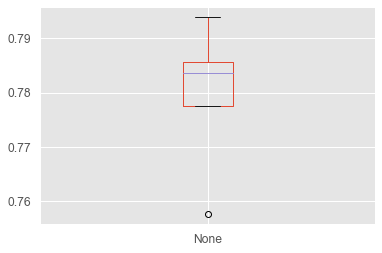

              precision    recall  f1-score   support

         0.0       0.66      0.70      0.68       281
         1.0       0.71      0.67      0.69       305

    accuracy                           0.69       586
   macro avg       0.69      0.69      0.69       586
weighted avg       0.69      0.69      0.69       586

1 dummy_roc_auc_score: 0.525645057953288
1 blind_roc_auc_score: 0.6865993815996734

Confusion Matrix
[[197  84]
 [100 205]]


In [88]:
#second round
print('second round')
fitted_model, params , blind_score= scripts.run_lgb(X[selected_features],y, params)

In [89]:
#ELI5 f selection
print('ELI5 will take some times to run')
score_df = scripts.eli_select(X[selected_features], y, params)
selected_features = list(score_df[score_df['fimp']>0.01]['f'])

ELI5 will take some times to run


In [90]:
#ELI5 df
score_df.sort_values('fimp',ascending=False).head(10)

,fimp,f
4,0.075627,EF_Abundance_BSF
3,0.060394,EF_CellCycle_min
0,0.048746,EF_merged_PCF_BSF
1,0.029450,EF_CellCycle_min_max
15,0.011470,EF_mRNA_BSF_vs_PCF
11,0.011350,EF_fc_glucose_1
14,0.010514,EF_RNA_BSF_to_PCF_sen_min
83,0.009737,ofer_w8: AA: N Frequency
74,0.009618,hp2: CACCA
52,0.008005,SolventA_3: Mirror K-mer : AAAHD


final round
DataSet size
X_train: (1088, 7) X_test: (586, 7) y_train: (1088,) y_test (586,)


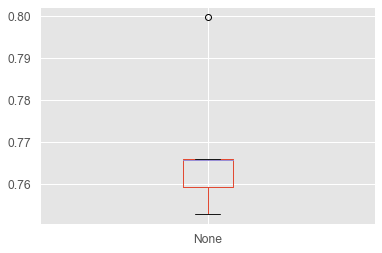

              precision    recall  f1-score   support

         0.0       0.67      0.72      0.69       278
         1.0       0.73      0.68      0.70       308

    accuracy                           0.70       586
   macro avg       0.70      0.70      0.70       586
weighted avg       0.70      0.70      0.70       586

1 dummy_roc_auc_score: 0.5015673615885705
1 blind_roc_auc_score: 0.698822759973839

Confusion Matrix
[[199  79]
 [ 98 210]]


In [91]:
#final round
print('final round')
fitted_model, params, blind_score = scripts.run_lgb(X[selected_features],y, params)    

### Feature Importance

SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. SHAP connects game theory with prediction explanations, uniting several previous methods to compute the feature importance in just one value (https://github.com/slundberg/shap).

In [92]:
X[selected_features].head()

,EF_merged_PCF_BSF,EF_CellCycle_min_max,EF_CellCycle_min,EF_Abundance_BSF,EF_fc_glucose_1,EF_RNA_BSF_to_PCF_sen_min,EF_mRNA_BSF_vs_PCF
16,-1.994036,0.213725,-999.0,8.097232,-0.076748,3.0,3.339756
123,-0.028742,0.263034,0.5,7.749779,-1.881199,4.0,2.893186
627,-0.028742,0.137504,0.5,7.300305,1.251539,3.0,0.242334
908,-0.028742,0.000000,0.5,7.911051,-0.258851,4.0,1.303662
945,-0.028742,0.263034,3.0,6.970981,-1.000000,4.0,2.673936


In [93]:
#Now we use the SHAP scoring system to visualise 
#the most important features for the model
explainer = shap.TreeExplainer(fitted_model)
shap_values = explainer.shap_values(X[selected_features])
#shap.summary_plot(shap_values, 
                  #train[train_features],
                  #max_display=100)

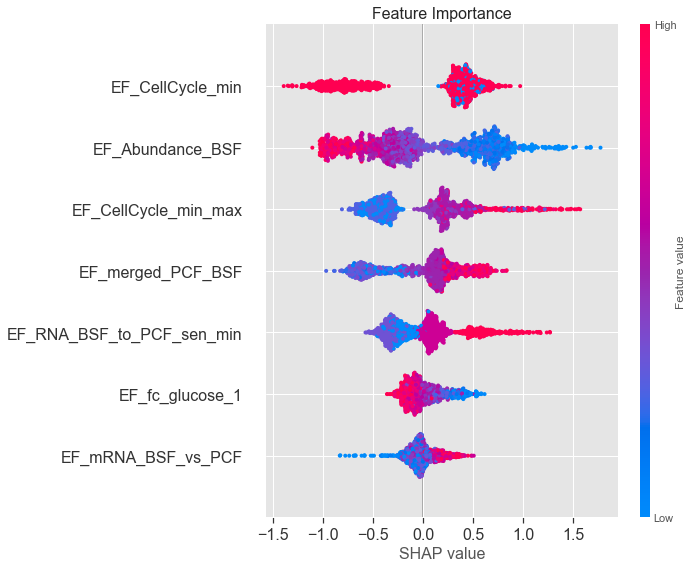

In [94]:
plt.style.use('ggplot')
shap.summary_plot(shap_values, 
                  X[selected_features], 
                  feature_names=troncate_name(list(X[selected_features].columns)),
                  max_display=15,show=False)
f = plt.gcf()
f.set_size_inches(10, 8)
plt.title('Feature Importance',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('SHAP value',fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join('figures','example_1','Fig_18.png'))
plt.show()
#print(r)

### SHAP explainer

In [95]:
temp = pd.concat([tryp_df[['Gene ID',
         'Product Description']].iloc[y.index.values],y],axis=1)

temp['index']=temp.index.values
temp = temp.set_index('Gene ID',drop=False)
temp = temp.join(turnover_bsf[['exp_residual_life', 'bins']],how='left')
temp.tail(15)

,Gene ID,Product Description,target,index,exp_residual_life,bins
Gene ID,,,,,,
Tb927.9.8700,Tb927.9.8700,"hypothetical protein, conserved",1.0,11435,3.226721,1
Tb927.9.8720,Tb927.9.8720,"fructose-1,6-bisphosphatase",0.0,11437,8.217282,10
Tb927.9.8760,Tb927.9.8760,"hypothetical protein, conserved",0.0,11439,7.048124,9
Tb927.9.9000,Tb927.9.9000,isopentenyl-diphosphate delta-isomerase (type II),0.0,11452,7.128898,10
Tb927.9.9080,Tb927.9.9080,Present in the outer mitochondrial membrane pr...,1.0,11457,4.349954,2
Tb927.9.9100,Tb927.9.9100,"hypothetical protein, conserved",1.0,11460,4.425334,2
Tb927.9.9220,Tb927.9.9220,ribonuclease P,1.0,11472,3.031730,1
Tb927.9.9270,Tb927.9.9270,"hypothetical protein, conserved",0.0,11475,8.224396,10
Tb927.9.9290,Tb927.9.9290,polyadenylate-binding protein 1,1.0,11477,3.231992,1


In [96]:
shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values[0,:], 
                X[selected_features].iloc[201,:])
                 #matplotlib=True,show=False)
#f = plt.gcf()
#f.set_size_inches(16, 3)
##plt.title('Feature Importance',fontsize=16)
#plt.xticks(fontsize=16)
#plt.yticks(fontsize=16)
#plt.xlabel('SHAP value',fontsize=16)
#plt.tight_layout()
#plt.savefig(os.path.join('figures','example_1','Fig_18.png'))
#p#lt.show()


### LIME explainer

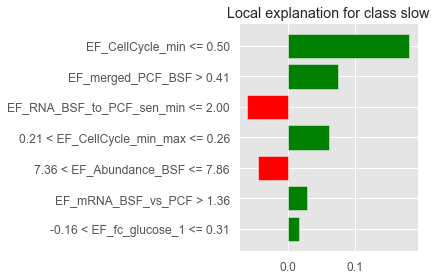

In [97]:

explainer = LimeTabularExplainer(
    training_data =X[selected_features].values,
    mode = 'classification',
    feature_names=selected_features,
    class_names=['fast','slow'],
    #categorical_features=categorical_features,
    )

# Now explain a prediction
exp = explainer.explain_instance(
    data_row=X[selected_features].iloc[50,:], 
    predict_fn = fitted_model.predict_proba,
    #labels=['fast','slow'],
    num_features=10)

exp.as_pyplot_figure()
from matplotlib import pyplot as plt
plt.tight_layout()

### Feature Analysis

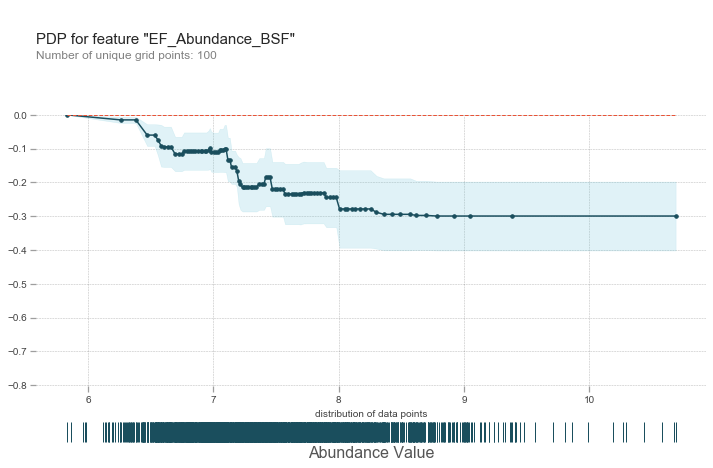

In [98]:
from pdpbox import pdp, get_dataset, info_plots
pdp_fare = pdp.pdp_isolate(
    model=fitted_model, dataset=impute(X[selected_features]), 
    model_features=selected_features, 
    feature='EF_Abundance_BSF',
    num_grid_points=100,
    n_jobs=4
)

f, axes = pdp.pdp_plot(pdp_fare, 'EF_Abundance_BSF',
                        plot_pts_dist=True)

f.set_size_inches(12, 8)
#matplotlib.rcParams.update({'font.size': 12})
#matplotlib.rcParams['figure.figsize'] = 18, 18


#plt.title('Feature Importance',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Abundance Value',fontsize=16)
plt.tight_layout()

### Look at possible feature interactions

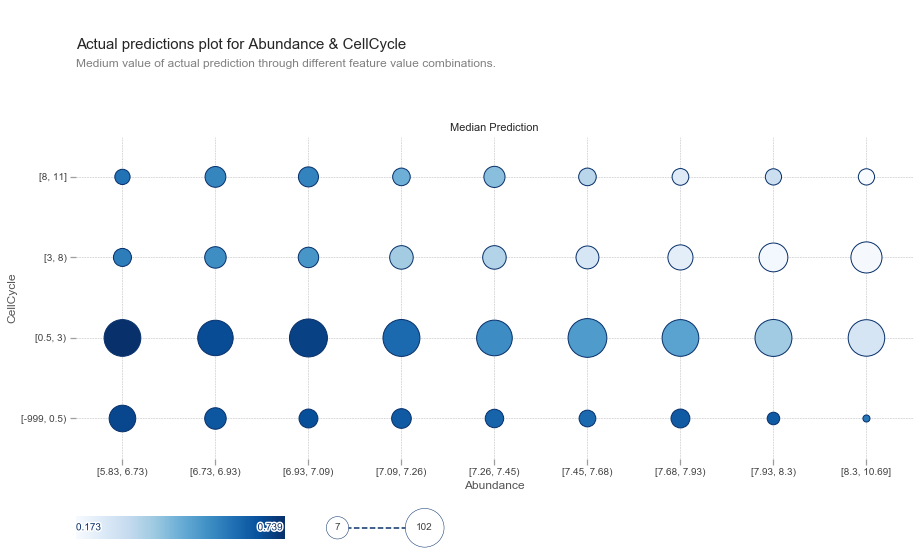

In [99]:
fig, axes, summary_df = info_plots.actual_plot_interact(
    model=fitted_model, X=impute(X[selected_features]), 
    features=['EF_Abundance_BSF', 
              'EF_CellCycle_min'], feature_names=['Abundance', 
                                                  'CellCycle'])
    

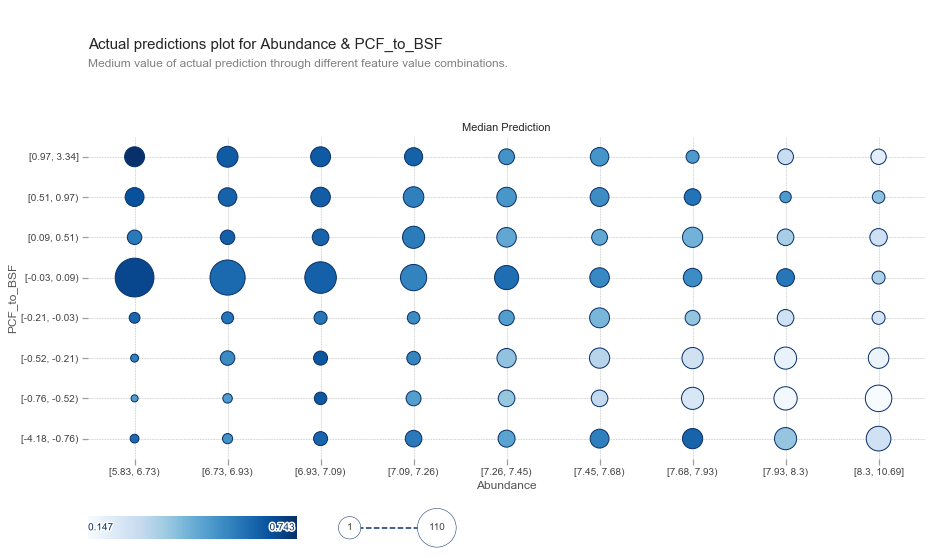

In [100]:
fig, axes, summary_df = info_plots.actual_plot_interact(
    model=fitted_model, X=impute(X[selected_features]), 
    features=['EF_Abundance_BSF', 
              'EF_merged_PCF_BSF'], feature_names=['Abundance',
                                                   'PCF_to_BSF'])
    

### Decision Tree visualization
we can plot the first tree used by the alghoritm to split the data

In [101]:
def render_tree(tree_index, show_info, precision=4):
    show_info = None if 'None' in show_info else show_info
    return lgb.create_tree_digraph(fitted_model, tree_index=tree_index,
                                   show_info=show_info, precision=precision)

In [102]:
try:
    from ipywidgets import interact, SelectMultiple
    INTERACTIVE = True
except ImportError:
    INTERACTIVE = False

if INTERACTIVE:
    # create widget to switch between trees and control info in nodes
    interact(render_tree,
             tree_index=(0, params['n_estimators']),
             show_info=SelectMultiple(  # allow multiple values to be selected
                 options=['None',
                          'split_gain',
                          'internal_value',
                          'internal_count',
                          'internal_weight',
                          'leaf_count',
                          'leaf_weight'],
                 value=['None']),
             precision=(0, 10))
    tree = None
else:
    tree = render_tree(84, ['None'])
tree

interactive(children=(IntSlider(value=3, description='tree_index', max=7), SelectMultiple(description='show_in…